In [1]:
import pandas as pd
from os.path import join, isdir, exists, basename, dirname
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from icecream import ic
from src.utils import variant_utils as vu
from glob import glob
from itertools import product
from collections import defaultdict
from tqdm.notebook import tqdm
import pickle

In [2]:
import matplotlib

In [3]:
# don_dir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/mt_clones_thresh/"
# #samples = "preB,postB"

# Params
# af_ts = [0.01, 0.1, 0.4, 0.8,]
# oth_af_ts = [0.01, 0.1, 0.4]
# cov_ts = [2, 10, 30] # mean coverage at position for cells with the AF
# oth_cov_ts = [2, 10, 30]  # mean coverage for cells without AF 
# num_cells = [5, 10, 30] # num cells and fraction are for cells with sufficient coverage
# oth_num_cells = [0.25, 0.6, 0.8] # fraction is of cells with sufficient coverage
# mean_pos_cov = [0, 10] #populatiion average coverage at that position


# indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/mt_clones_thresh"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/plot_mt_clones_thresh"

indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/mt_as_clones/variants_simpleUnion/mt_clones_thresh"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/mt_as_clones/variants_simpleUnion/mt_clones_thresh"
N_DONORS = 2

In [4]:
# use_small = snakemake.params.get("use_small", False)
# to_plots = snakemake.params.get("to_plots", True)
# don_dir = snakemake.input["don_dir"]
# outdir = snakemake.params["outdir"]

# params = snakemake.config["mt_as_clones"]["params"]
# af_ts = params["af_ts"]
# oth_af_ts = params["oth_af_ts"]
# cov_ts = params["cov_ts"]
# oth_cov_ts = params["oth_cov_ts"]
# num_cells = params["num_cells"]
# oth_num_cells = params["oth_num_cells"]
# mean_pos_cov = params["mean_pos_cov"]

In [5]:
cells_dir = join(indir, "cells")
cells_dir

'/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/mt_as_clones/variants_simpleUnion/mt_clones_thresh/cells'

In [6]:
params_d = {}
cell_vars_d = {}

for d in np.arange(N_DONORS): 
    params_d[d] = pd.read_csv(join(indir, f"donor_{d}_thresh_results.tsv"), sep="\t")
    for thresh, curr_df in params_d[d].groupby(["af", "oth_af", "cov", "oth_cov"]):
        print(thresh)
        curr_f = join(cells_dir, f"don.{d}_af.{thresh[0]}_othaf.{thresh[1]}_cov.{thresh[2]}_othcov.{thresh[3]}.p")
        cell_vars_d[(thresh, d)] = pickle.load(open(curr_f,'rb'))    
        clone_cells = set()
        for x in cell_vars_d[(thresh,d)]:
            clone_cells = clone_cells.union(set(cell_vars_d[(thresh,d)][x]["clone_cells"])) 

        params_d[d].loc[curr_df.index, "cells_with_a_var"] = len(clone_cells)
        
        curr_median_cells = {}
        curr_clone_cells = {}
        var_cells = dict()
        for ind, val in curr_df.iterrows():
            if pd.isnull(val["Variants"]):
                continue
            curr_vars = val["Variants"].split(";")
            curr_ncells = []
            curr_cells = set()
            for x in cell_vars_d[(thresh,d)]:
                if x in curr_vars:
                    curr_ncells.append(len(set(cell_vars_d[(thresh,d)])))
                    curr_cells = curr_cells.union(set(cell_vars_d[(thresh,d)][x]["clone_cells"])) 

            curr_median_cells[ind] = np.median(curr_ncells)
            curr_clone_cells[ind] = len(curr_cells)
        curr_median = pd.DataFrame(curr_median_cells, index=["median_cells"]).transpose()
        params_d[d].loc[curr_median.index,"median_cells"] = curr_median["median_cells"]
        params_d[d].loc[curr_median.index,"unique_ncells_captured"] = curr_clone_cells
        
        af_order = np.sort(params_d[d]["af"].unique())
        cov_order = np.sort(params_d[d]["cov"].unique())
        oth_af_order = np.sort(params_d[d]["oth_af"].unique())
        
    params_d[d] = params_d[d].astype(object)
    params_d[d]["af"] = params_d[d]["af"].apply(lambda x: f"af_{x}")
    params_d[d]["oth_af"] = params_d[d]["oth_af"].apply(lambda x: f"oth_af_{x}")
    params_d[d]["cov"] = params_d[d]["cov"].apply(lambda x: f"cov_{x}")
    params_d[d] = params_d[d].drop("mean_cov", axis=1).drop_duplicates() #not implemented yet

    

(0.01, 0.01, 2, 2)
(0.01, 0.01, 2, 10)
(0.01, 0.01, 2, 30)
(0.01, 0.01, 10, 2)
(0.01, 0.01, 10, 10)
(0.01, 0.01, 10, 30)
(0.01, 0.01, 30, 2)
(0.01, 0.01, 30, 10)
(0.01, 0.01, 30, 30)
(0.01, 0.1, 2, 2)
(0.01, 0.1, 2, 10)
(0.01, 0.1, 2, 30)
(0.01, 0.1, 10, 2)
(0.01, 0.1, 10, 10)
(0.01, 0.1, 10, 30)
(0.01, 0.1, 30, 2)
(0.01, 0.1, 30, 10)
(0.01, 0.1, 30, 30)
(0.01, 0.4, 2, 2)
(0.01, 0.4, 2, 10)
(0.01, 0.4, 2, 30)
(0.01, 0.4, 10, 2)
(0.01, 0.4, 10, 10)
(0.01, 0.4, 10, 30)
(0.01, 0.4, 30, 2)
(0.01, 0.4, 30, 10)
(0.01, 0.4, 30, 30)
(0.1, 0.01, 2, 2)
(0.1, 0.01, 2, 10)
(0.1, 0.01, 2, 30)
(0.1, 0.01, 10, 2)
(0.1, 0.01, 10, 10)
(0.1, 0.01, 10, 30)
(0.1, 0.01, 30, 2)
(0.1, 0.01, 30, 10)
(0.1, 0.01, 30, 30)
(0.1, 0.1, 2, 2)
(0.1, 0.1, 2, 10)
(0.1, 0.1, 2, 30)
(0.1, 0.1, 10, 2)
(0.1, 0.1, 10, 10)
(0.1, 0.1, 10, 30)
(0.1, 0.1, 30, 2)
(0.1, 0.1, 30, 10)
(0.1, 0.1, 30, 30)
(0.1, 0.4, 2, 2)
(0.1, 0.4, 2, 10)
(0.1, 0.4, 2, 30)
(0.1, 0.4, 10, 2)
(0.1, 0.4, 10, 10)
(0.1, 0.4, 10, 30)
(0.1, 0.4, 30, 2)
(0.

In [7]:
#     curr_p = params_results.loc[(params_results["af"]==af_t) &
#                        (params_results["oth_af"]==oth_af_t) &
#                        (params_results["cov"]==cov_t) &
#                        (params_results["oth_cov"]==oth_cov_t) &
#                        (params_results["ncells"]==ncells) &
#                        (params_results["oth_ncells"]==oth_ncells) &
#                        (params_results["mean_cov"]==mean_pos_cov)]
#     assert(len(curr_p)==1)
    
#     ## Construct a binary cell-by-variant matrix for the kept variants. 
#     ## Can add N/A if not in oth cells
#     curr_vars = curr_p.iloc[0]["Variants"].split(";")

#     all_cells = set()
#     for x in curr_cells:
#         all_cells = all_cells.union(set(curr_cells[x]["clone_cells"])) 
#         all_cells = all_cells.union(set(curr_cells[x]["other_cells"])) 


In [8]:
sns.set(font_scale=2)

oth_cov 2
oth_cov 10
oth_cov 30
oth_cov 2
oth_cov 10
oth_cov 30


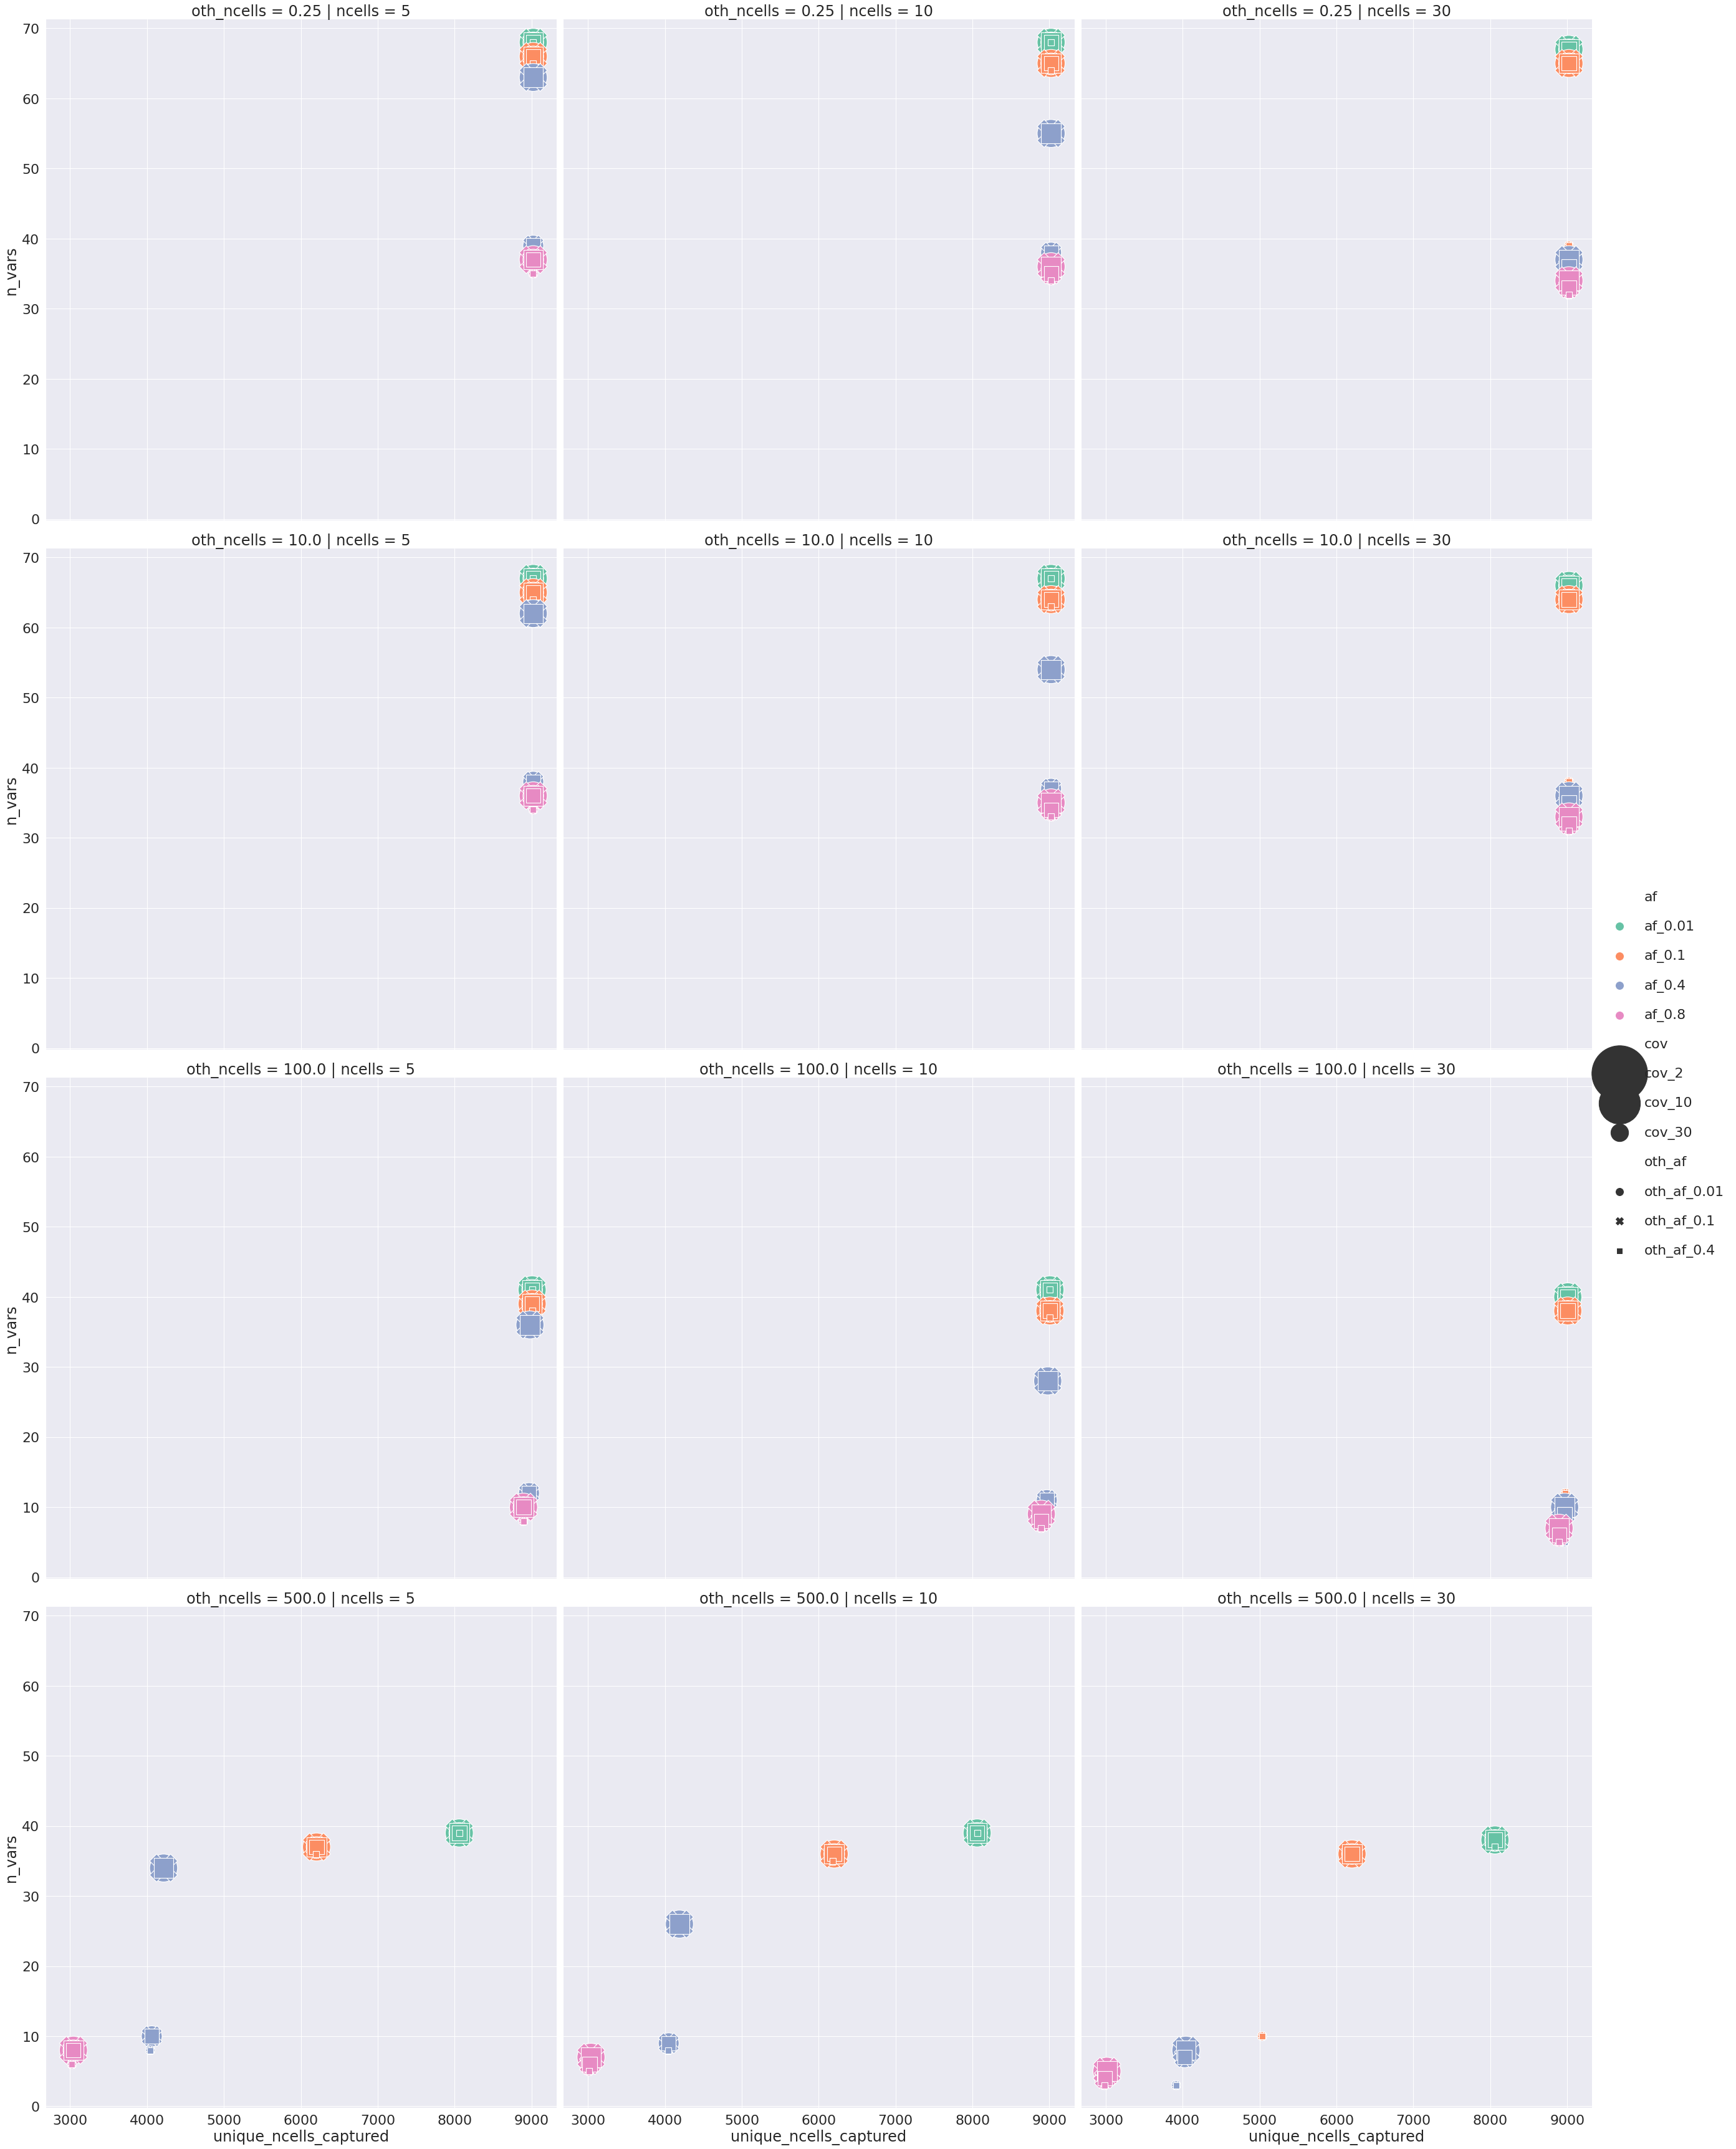

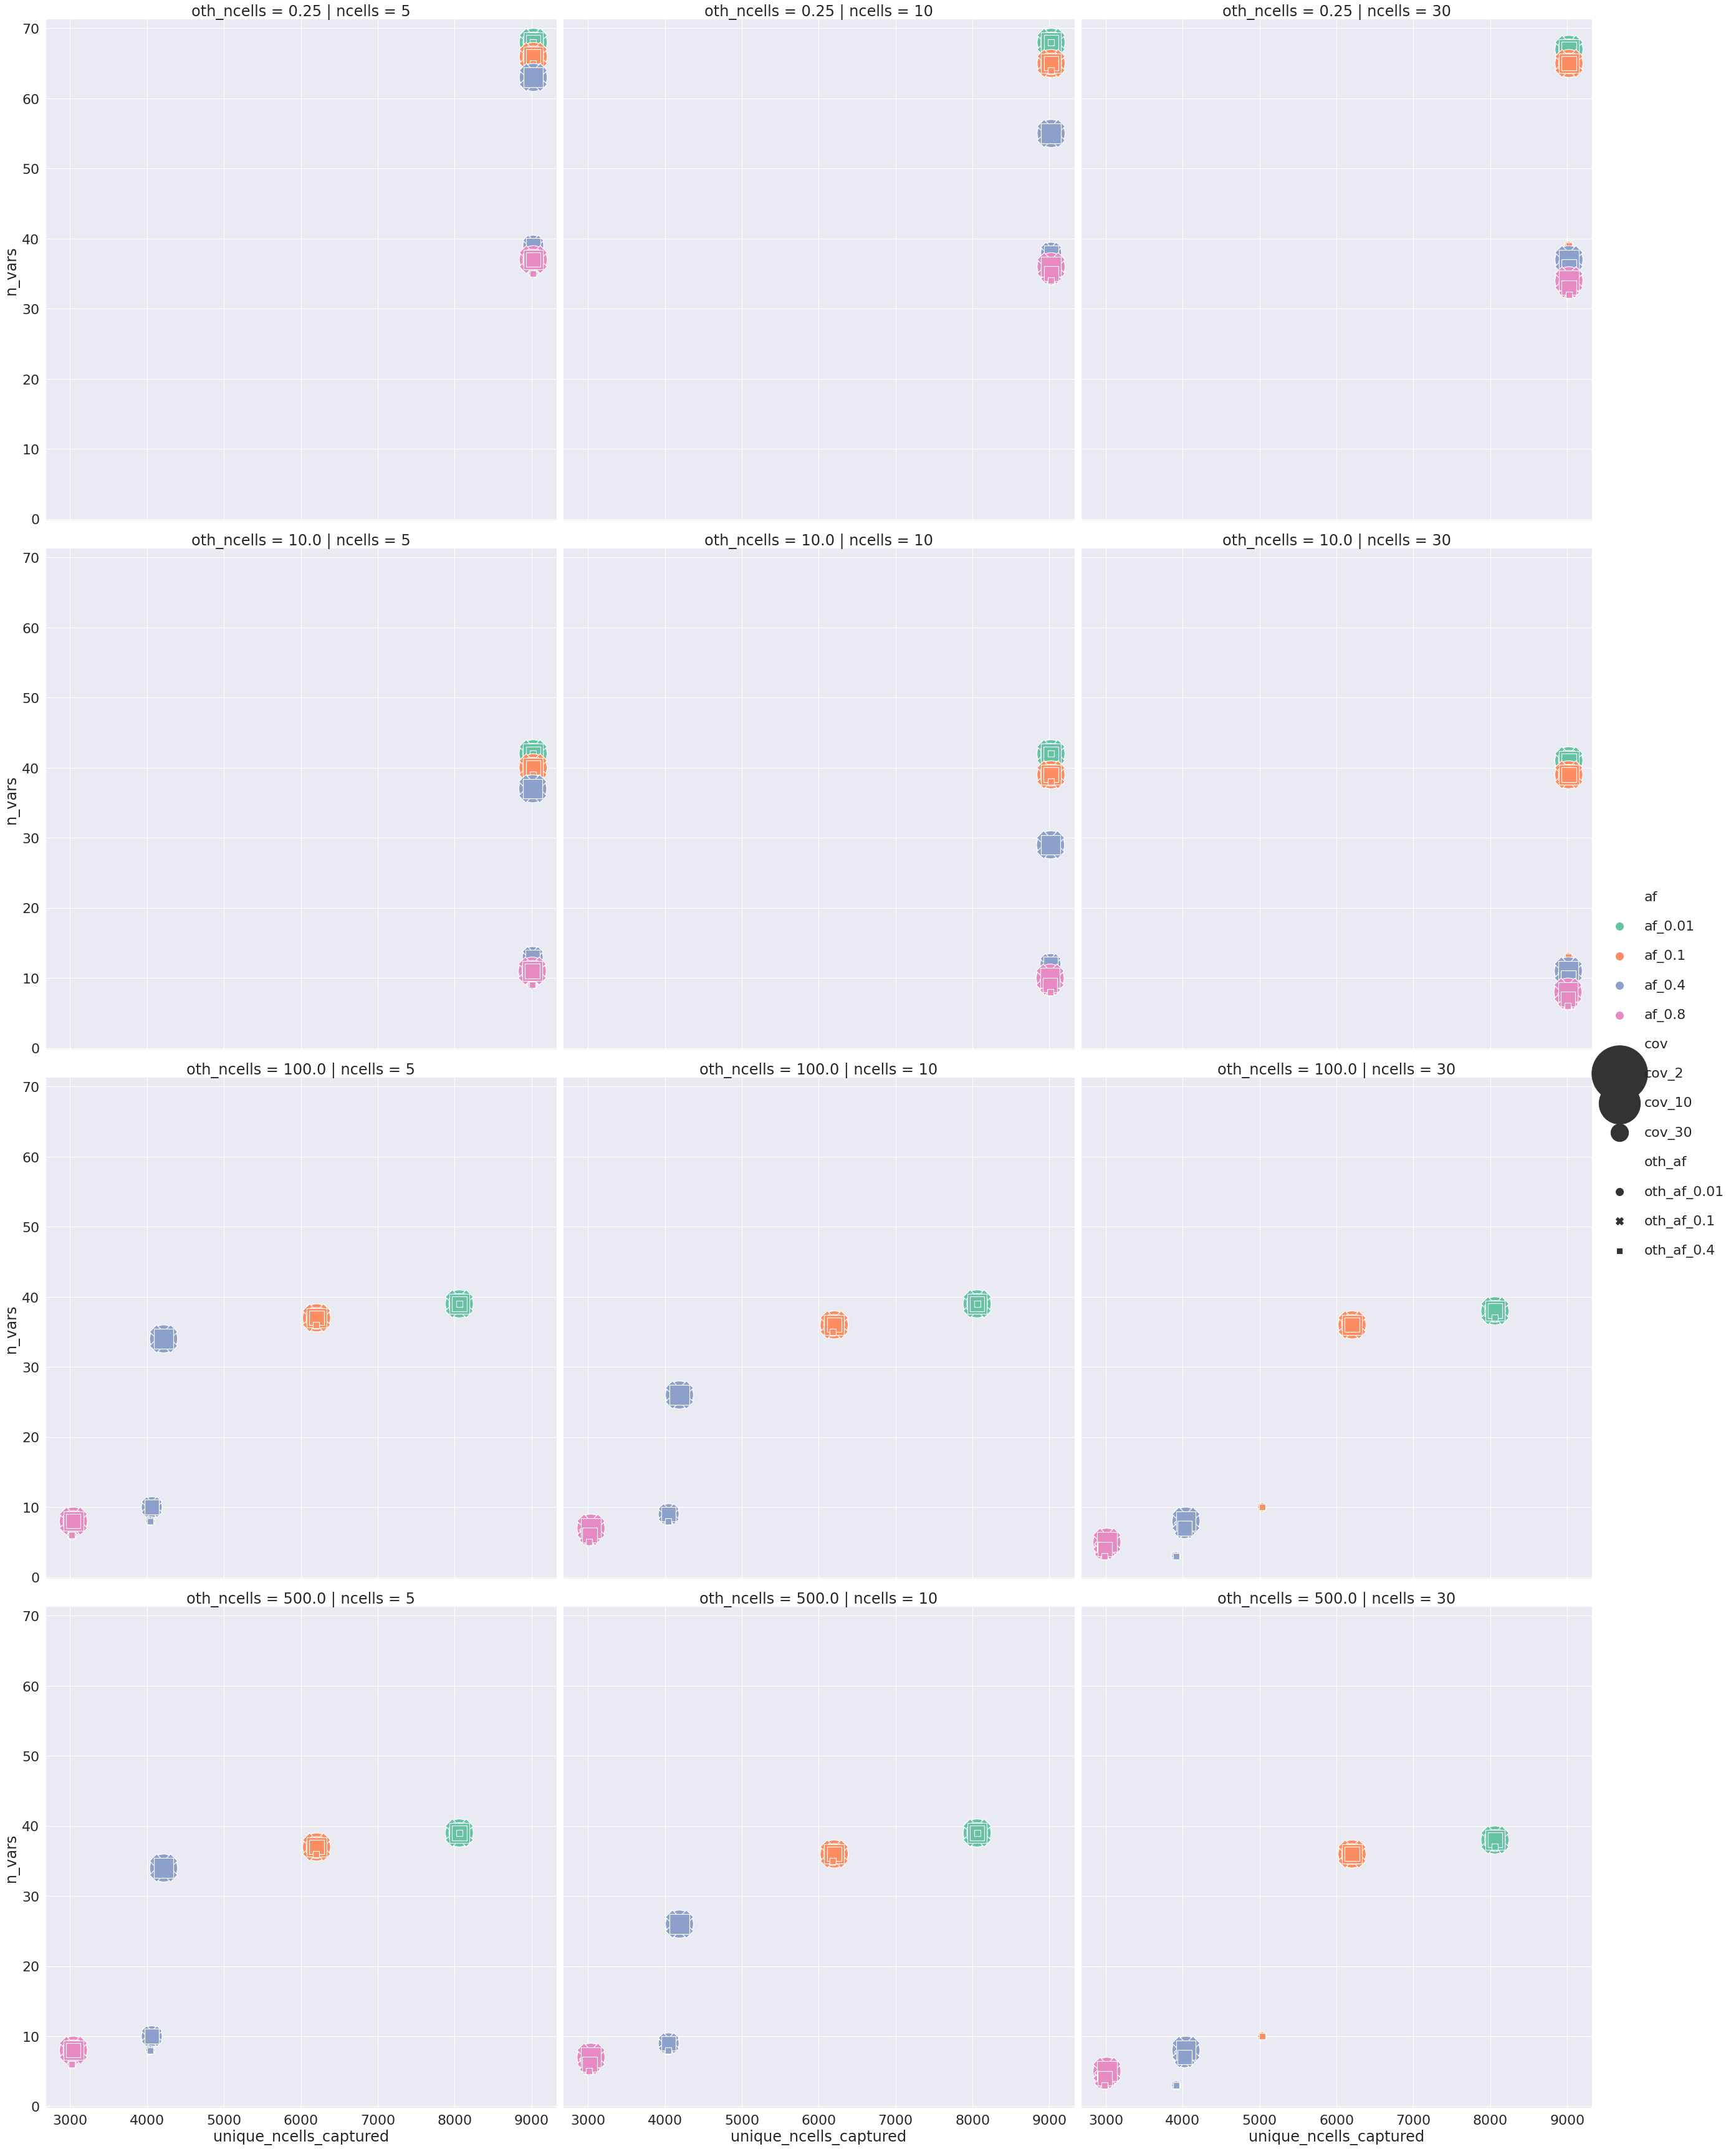

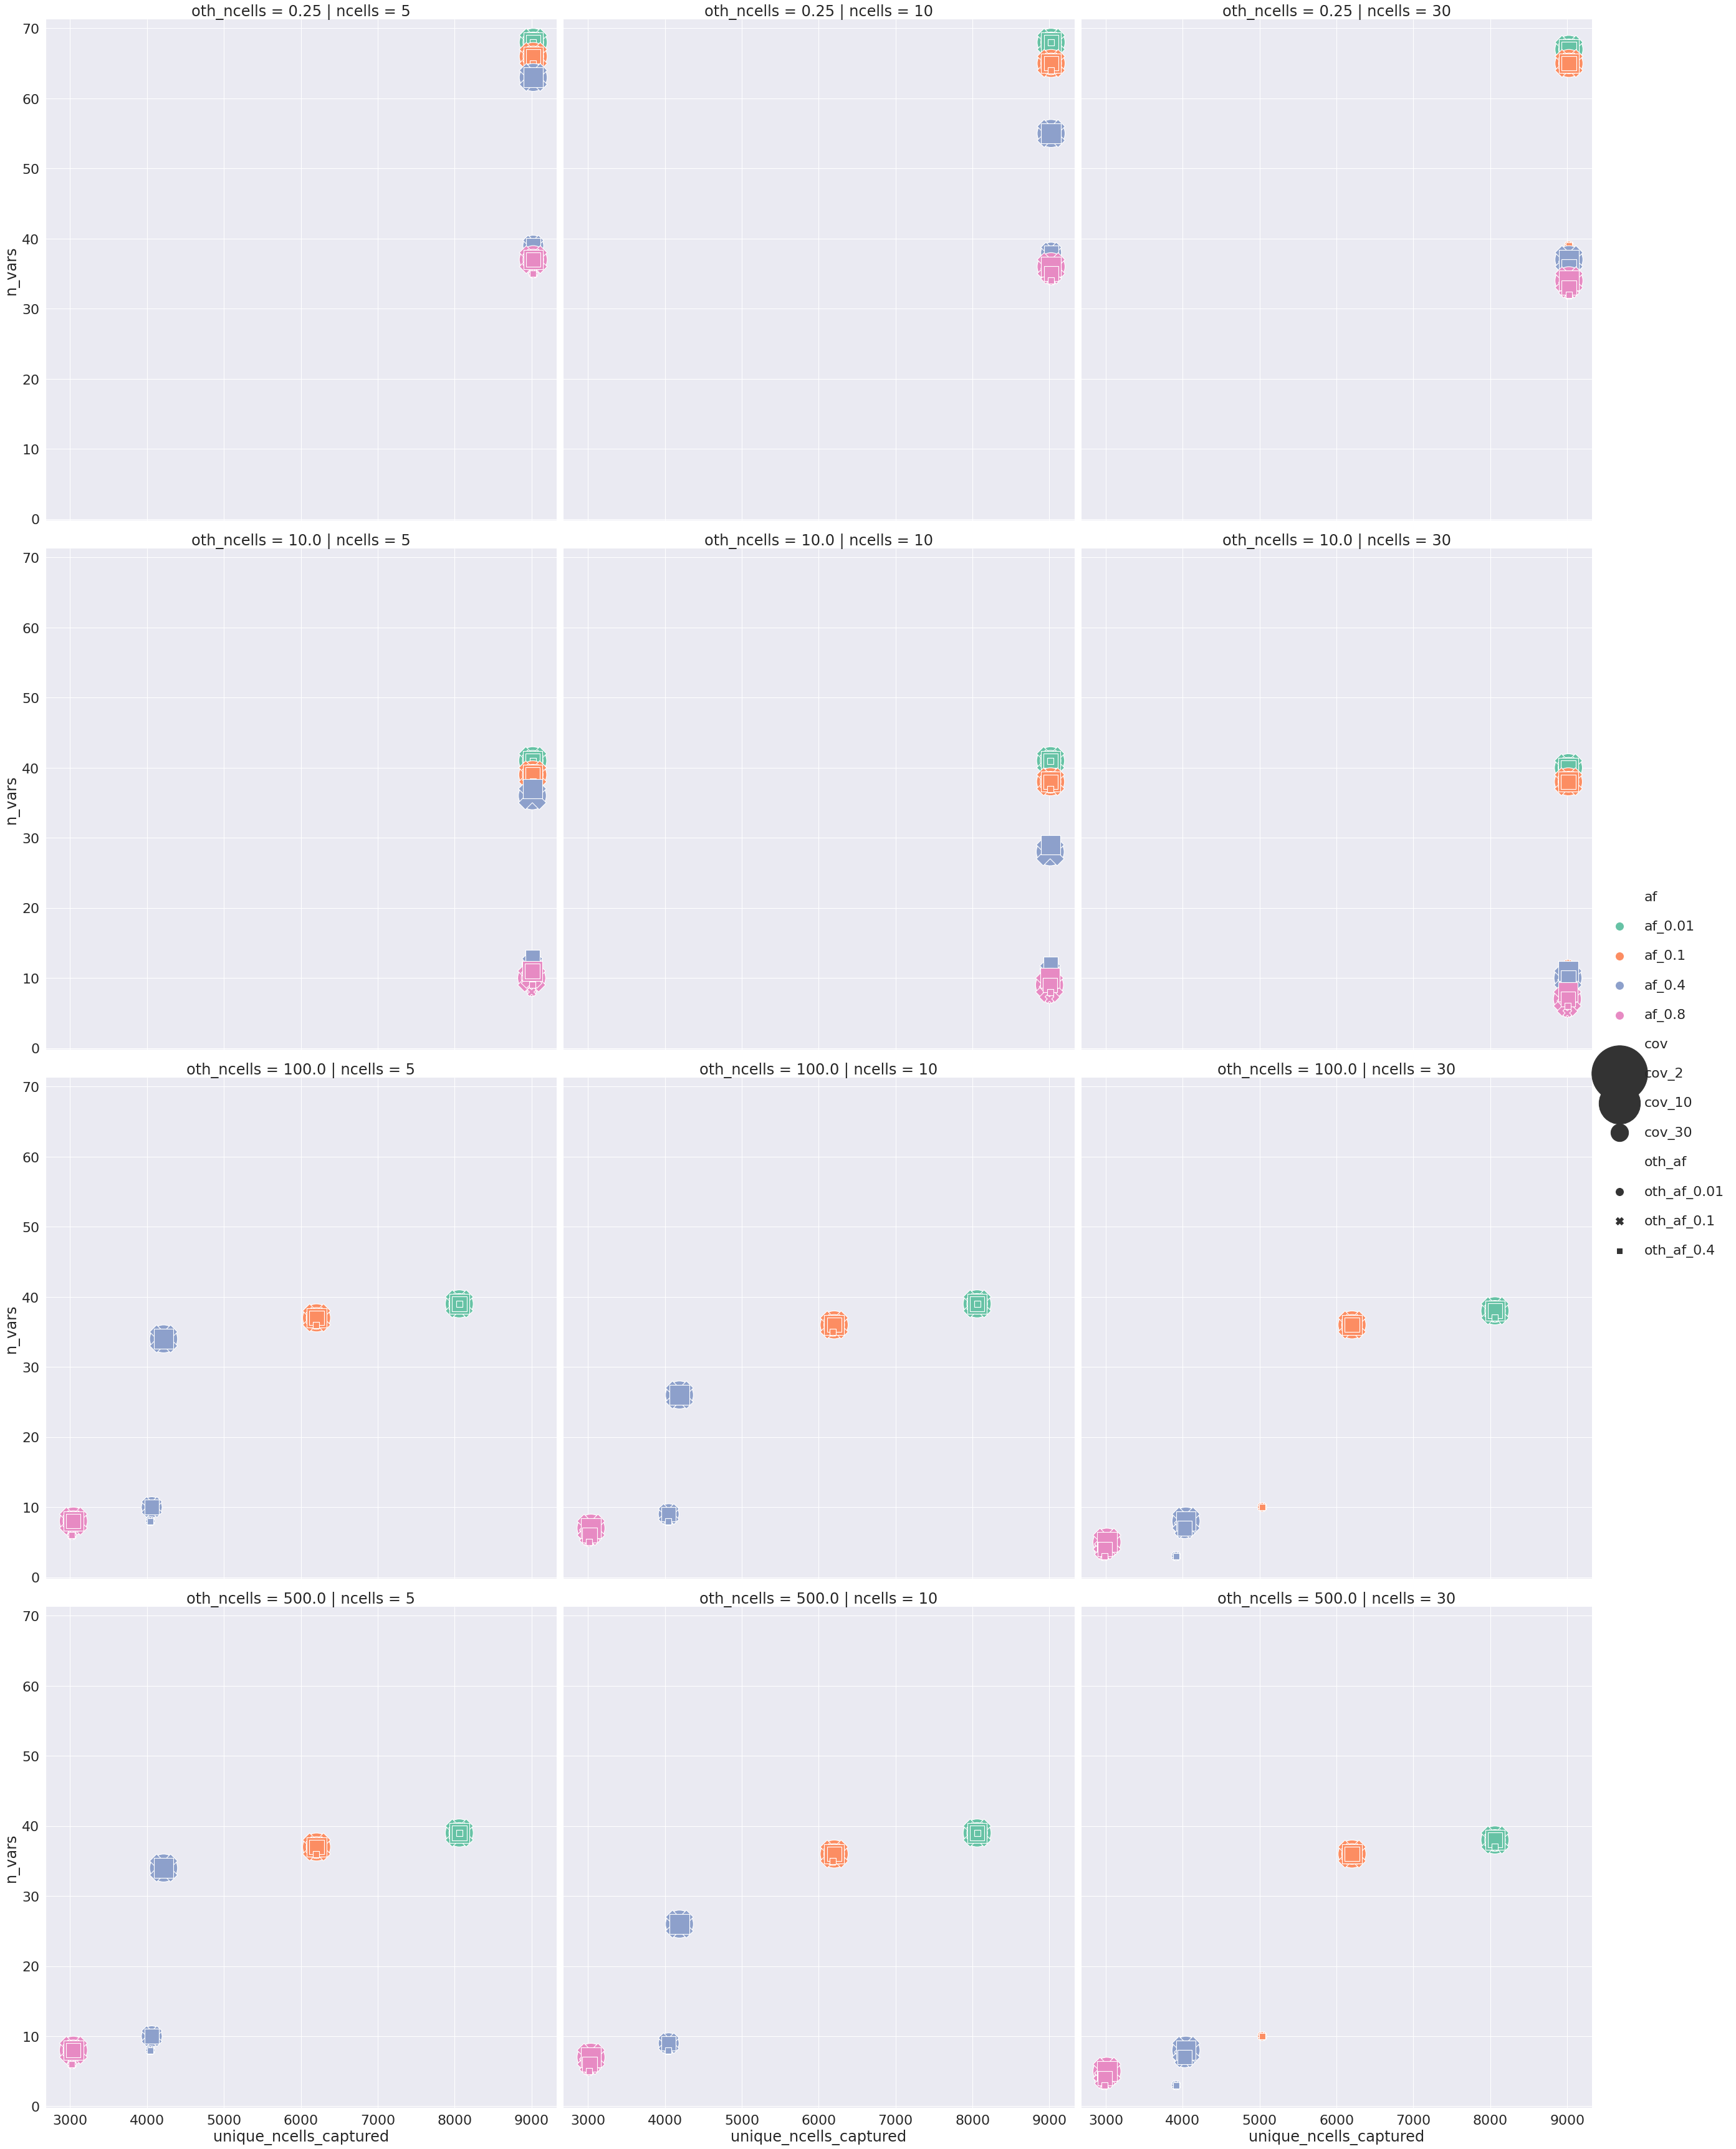

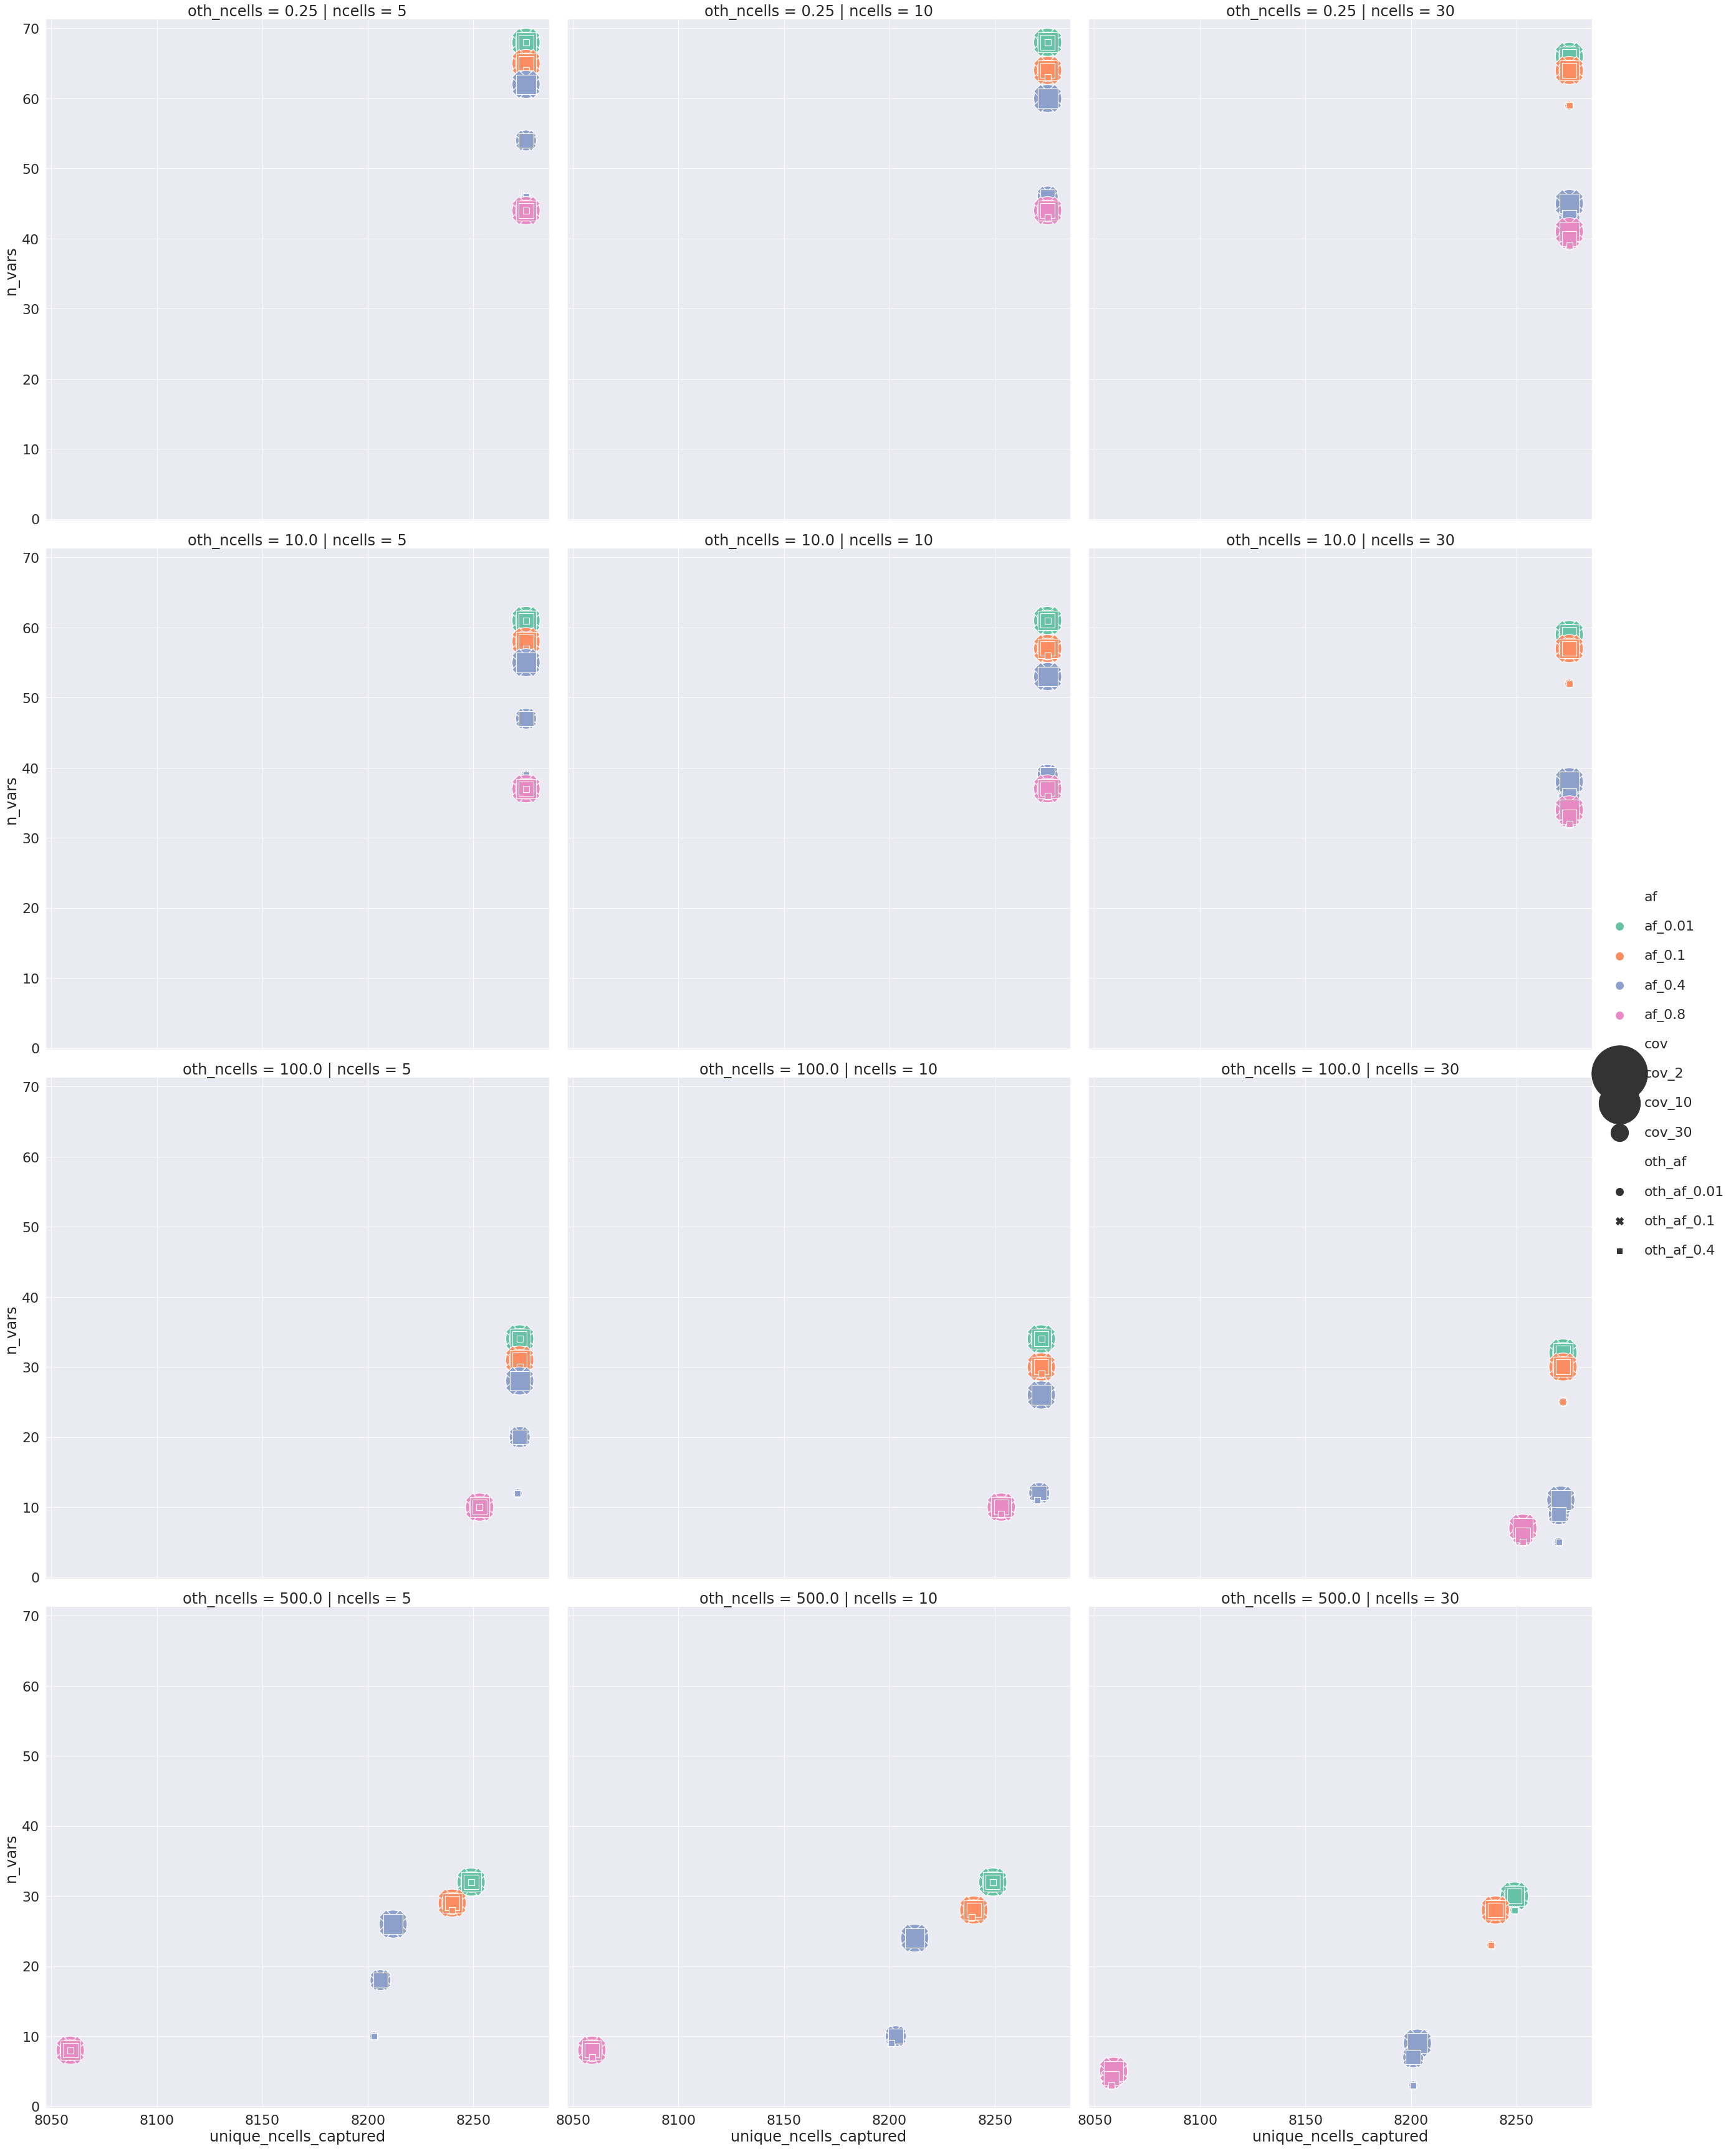

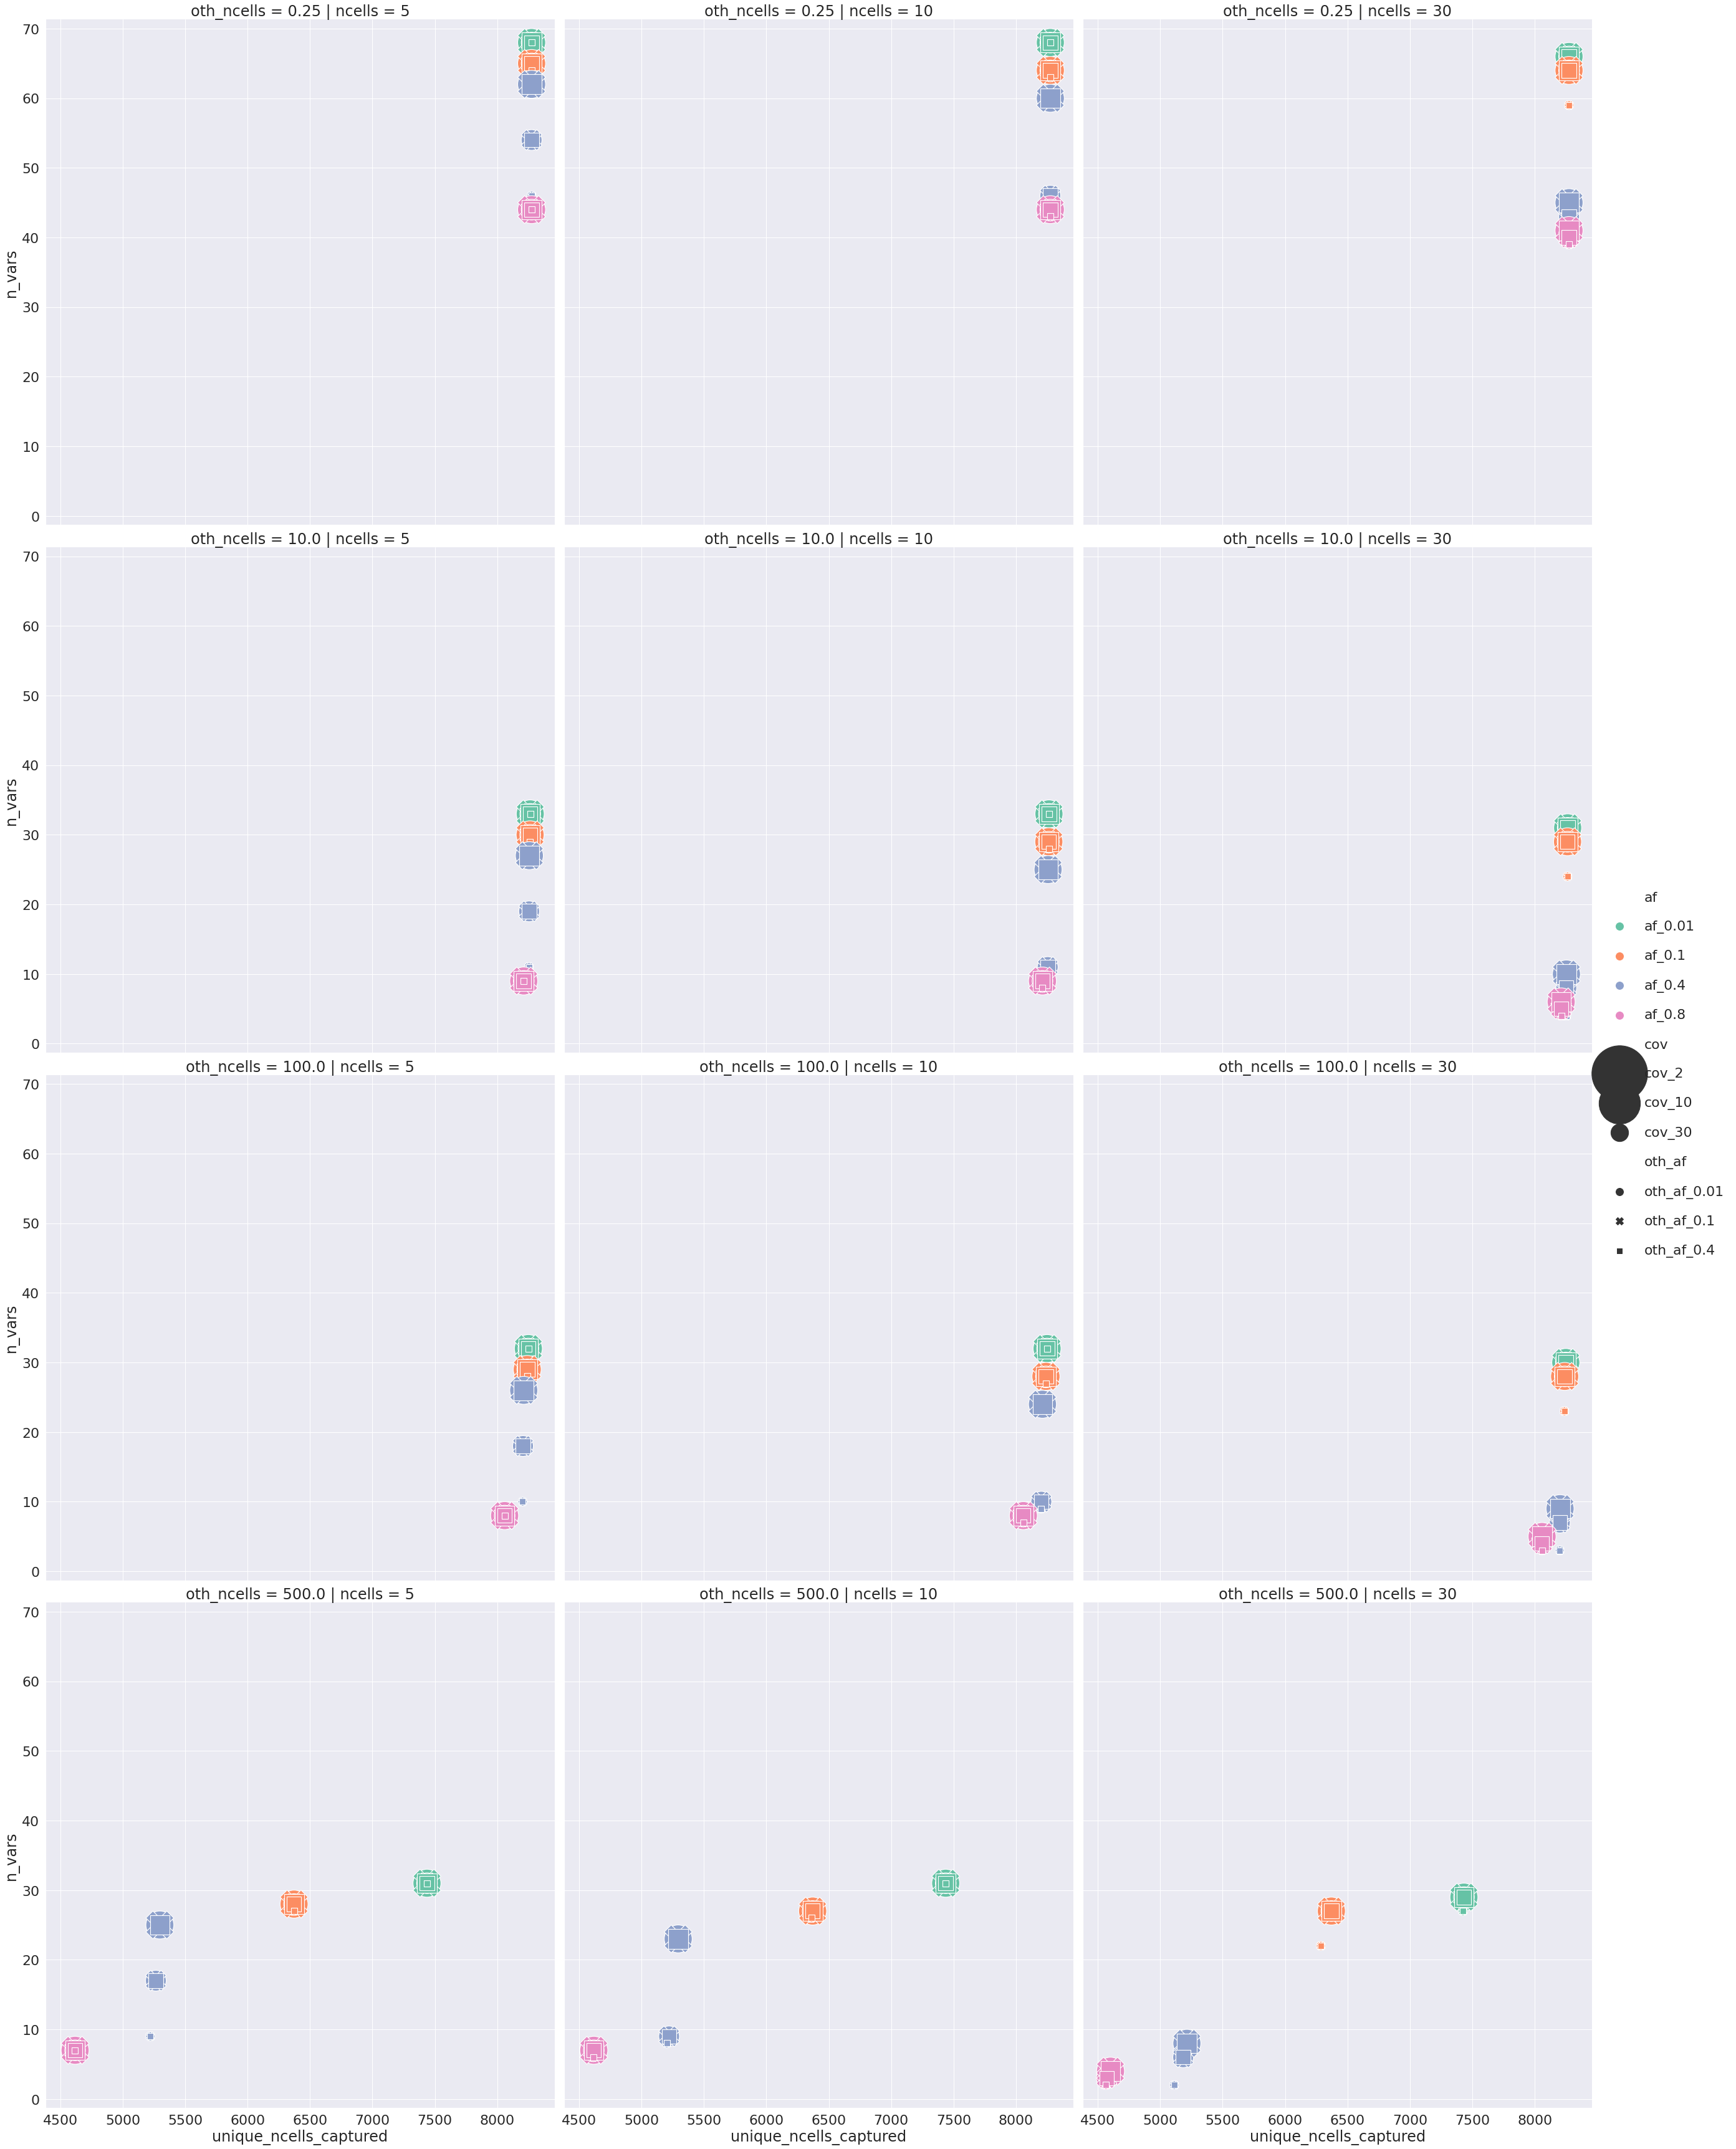

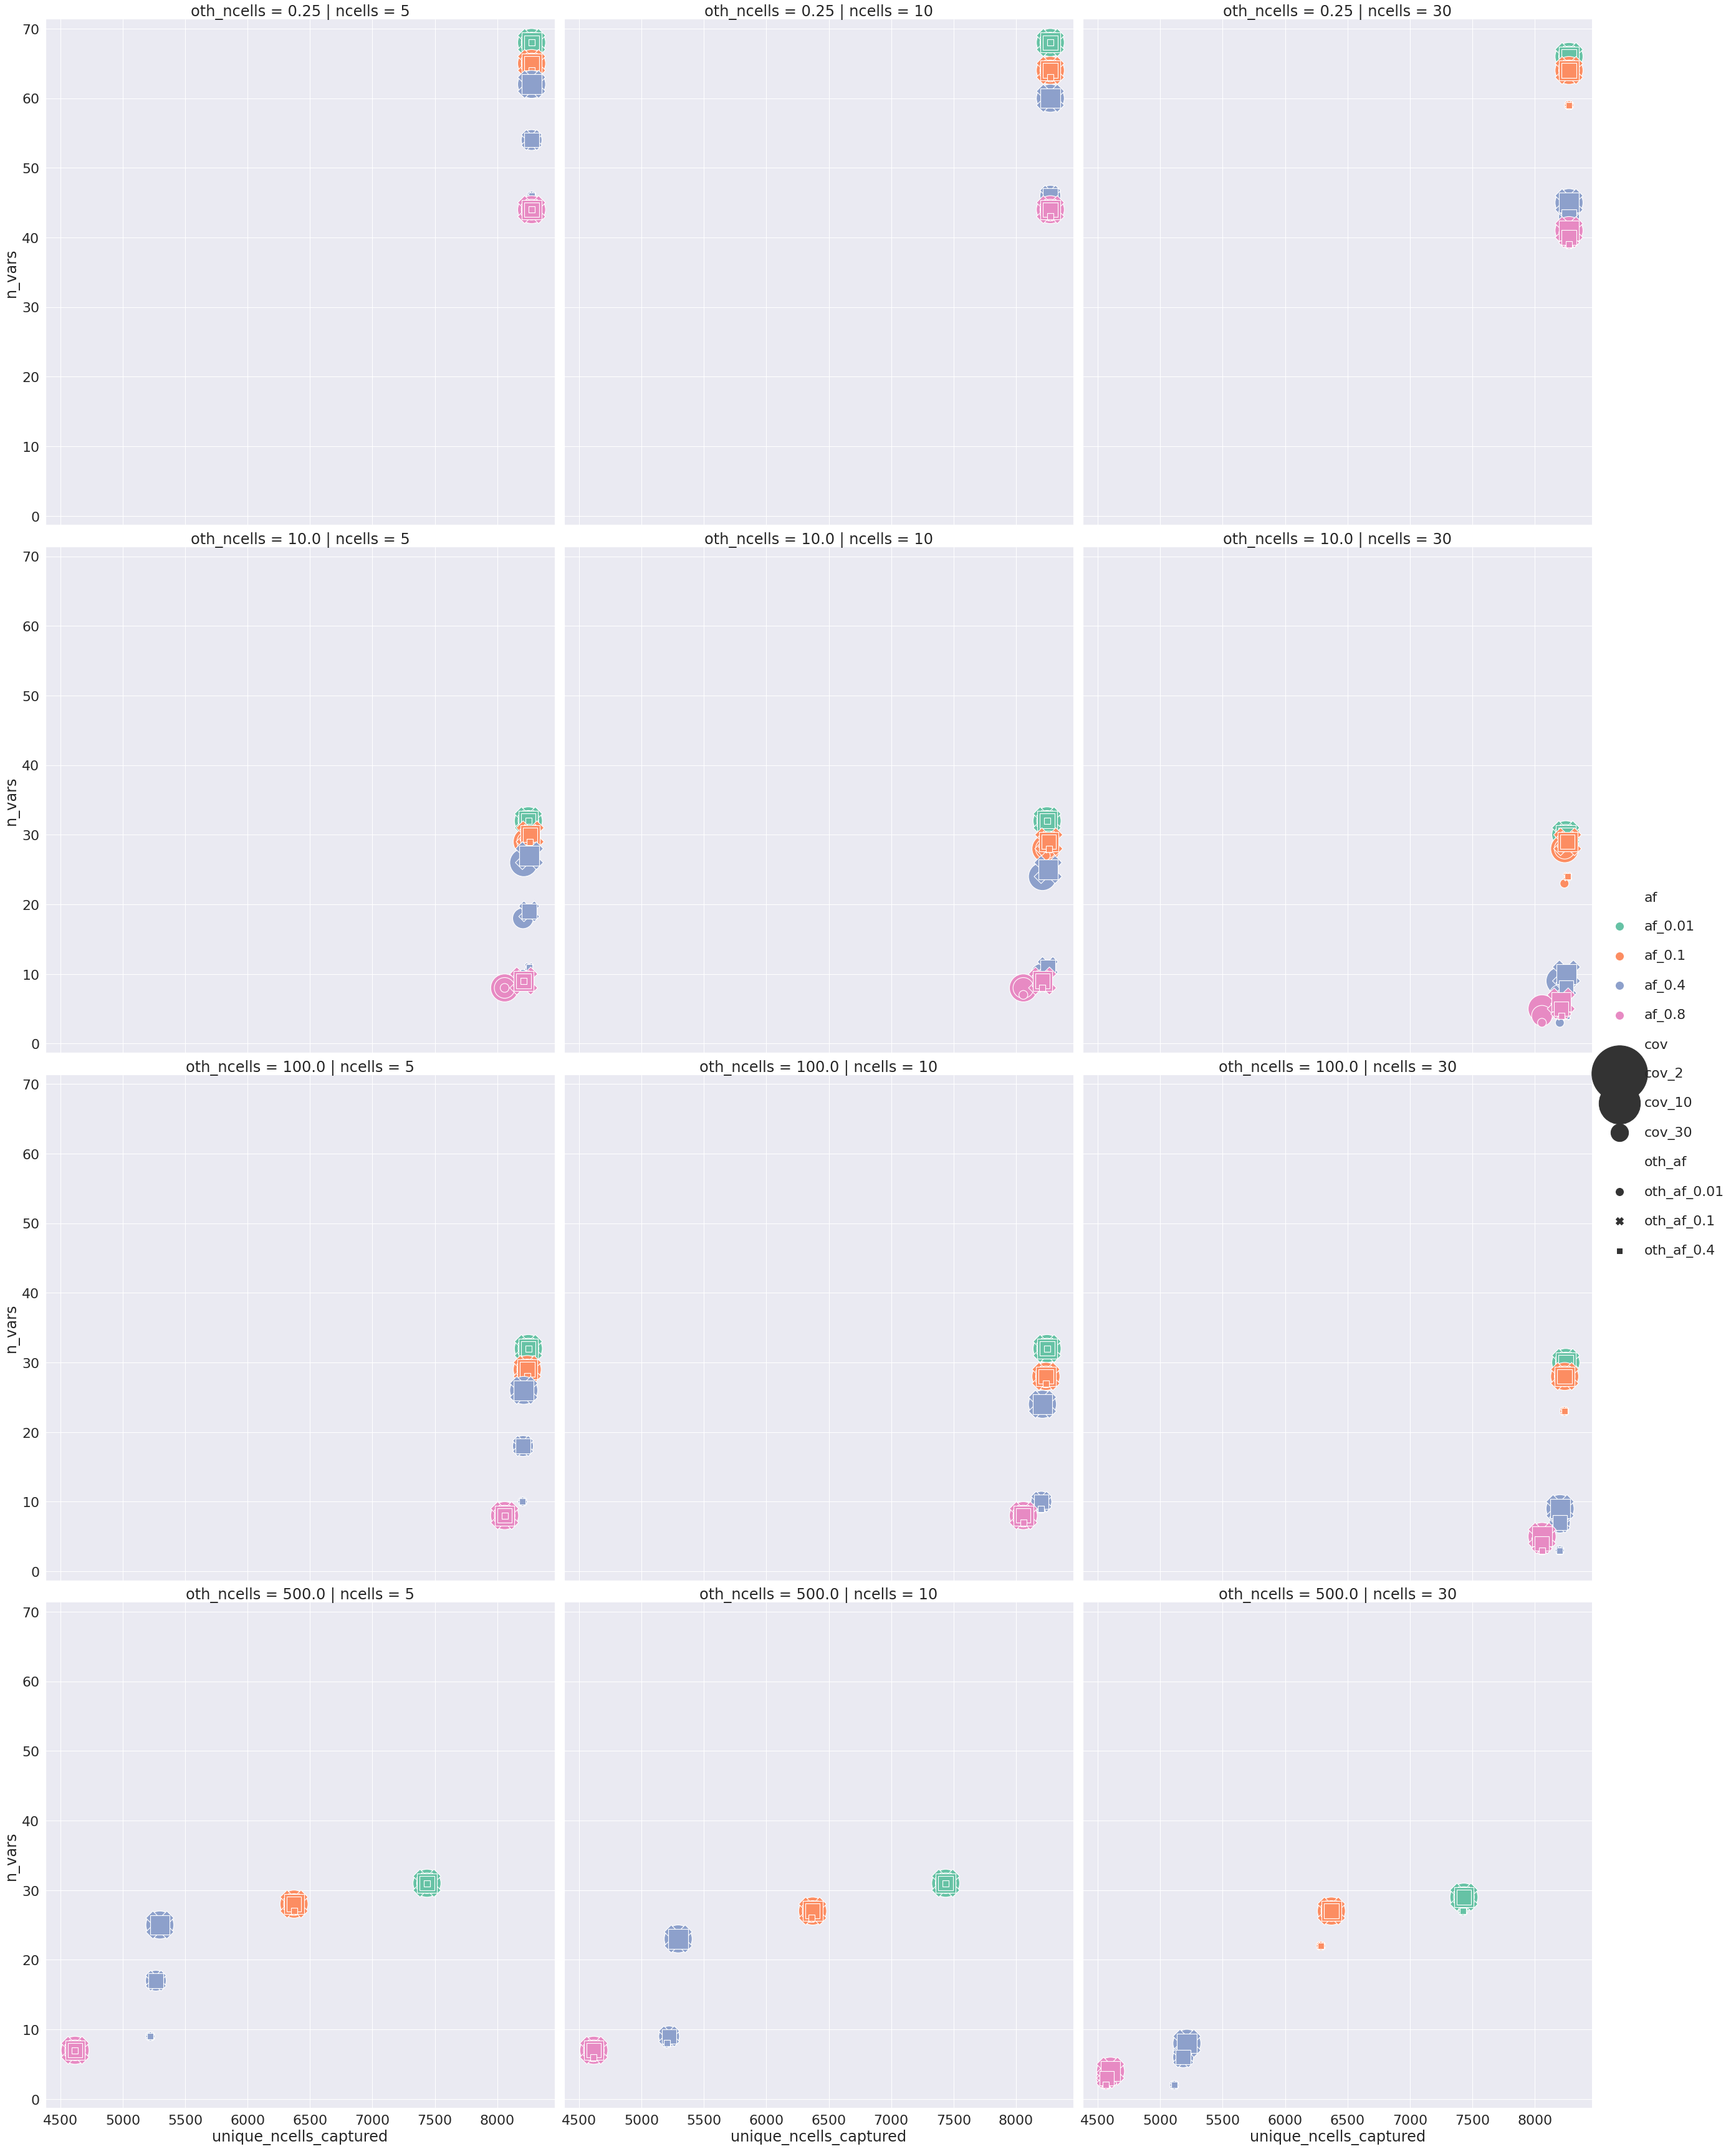

In [9]:
%matplotlib inline
for d in params_d:
    for oth_cov, val in params_d[d].groupby("oth_cov"):
        print('oth_cov', oth_cov)
        
        val["log2_unique_ncells_captured"] =np.log2(1+val["unique_ncells_captured"].astype(int))
        g = sns.FacetGrid(data=val, legend_out=True, 
                          col="ncells", row="oth_ncells",  height=12, sharex=True, sharey=True, 
                          )
        g.map_dataframe(sns.scatterplot, x="unique_ncells_captured", y="n_vars", palette='Set2',
                        hue="af",style="oth_af", size="cov", size_order = [f"cov_{x}" for x in cov_order],
                        hue_order=[f"af_{x}" for x in af_order], style_order=[f"oth_af_{x}" for x in oth_af_order],
                       sizes=(200, 2000), x_jitter=True, y_jitter=True)
        g.add_legend(markerscale=2,labelspacing=1.2)
        plt.savefig(join(outdir, f"donor{d}_othcov_{oth_cov}_params_scatter.png"))

oth_cov 2
oth_cov 10
oth_cov 30
oth_cov 2
oth_cov 10
oth_cov 30


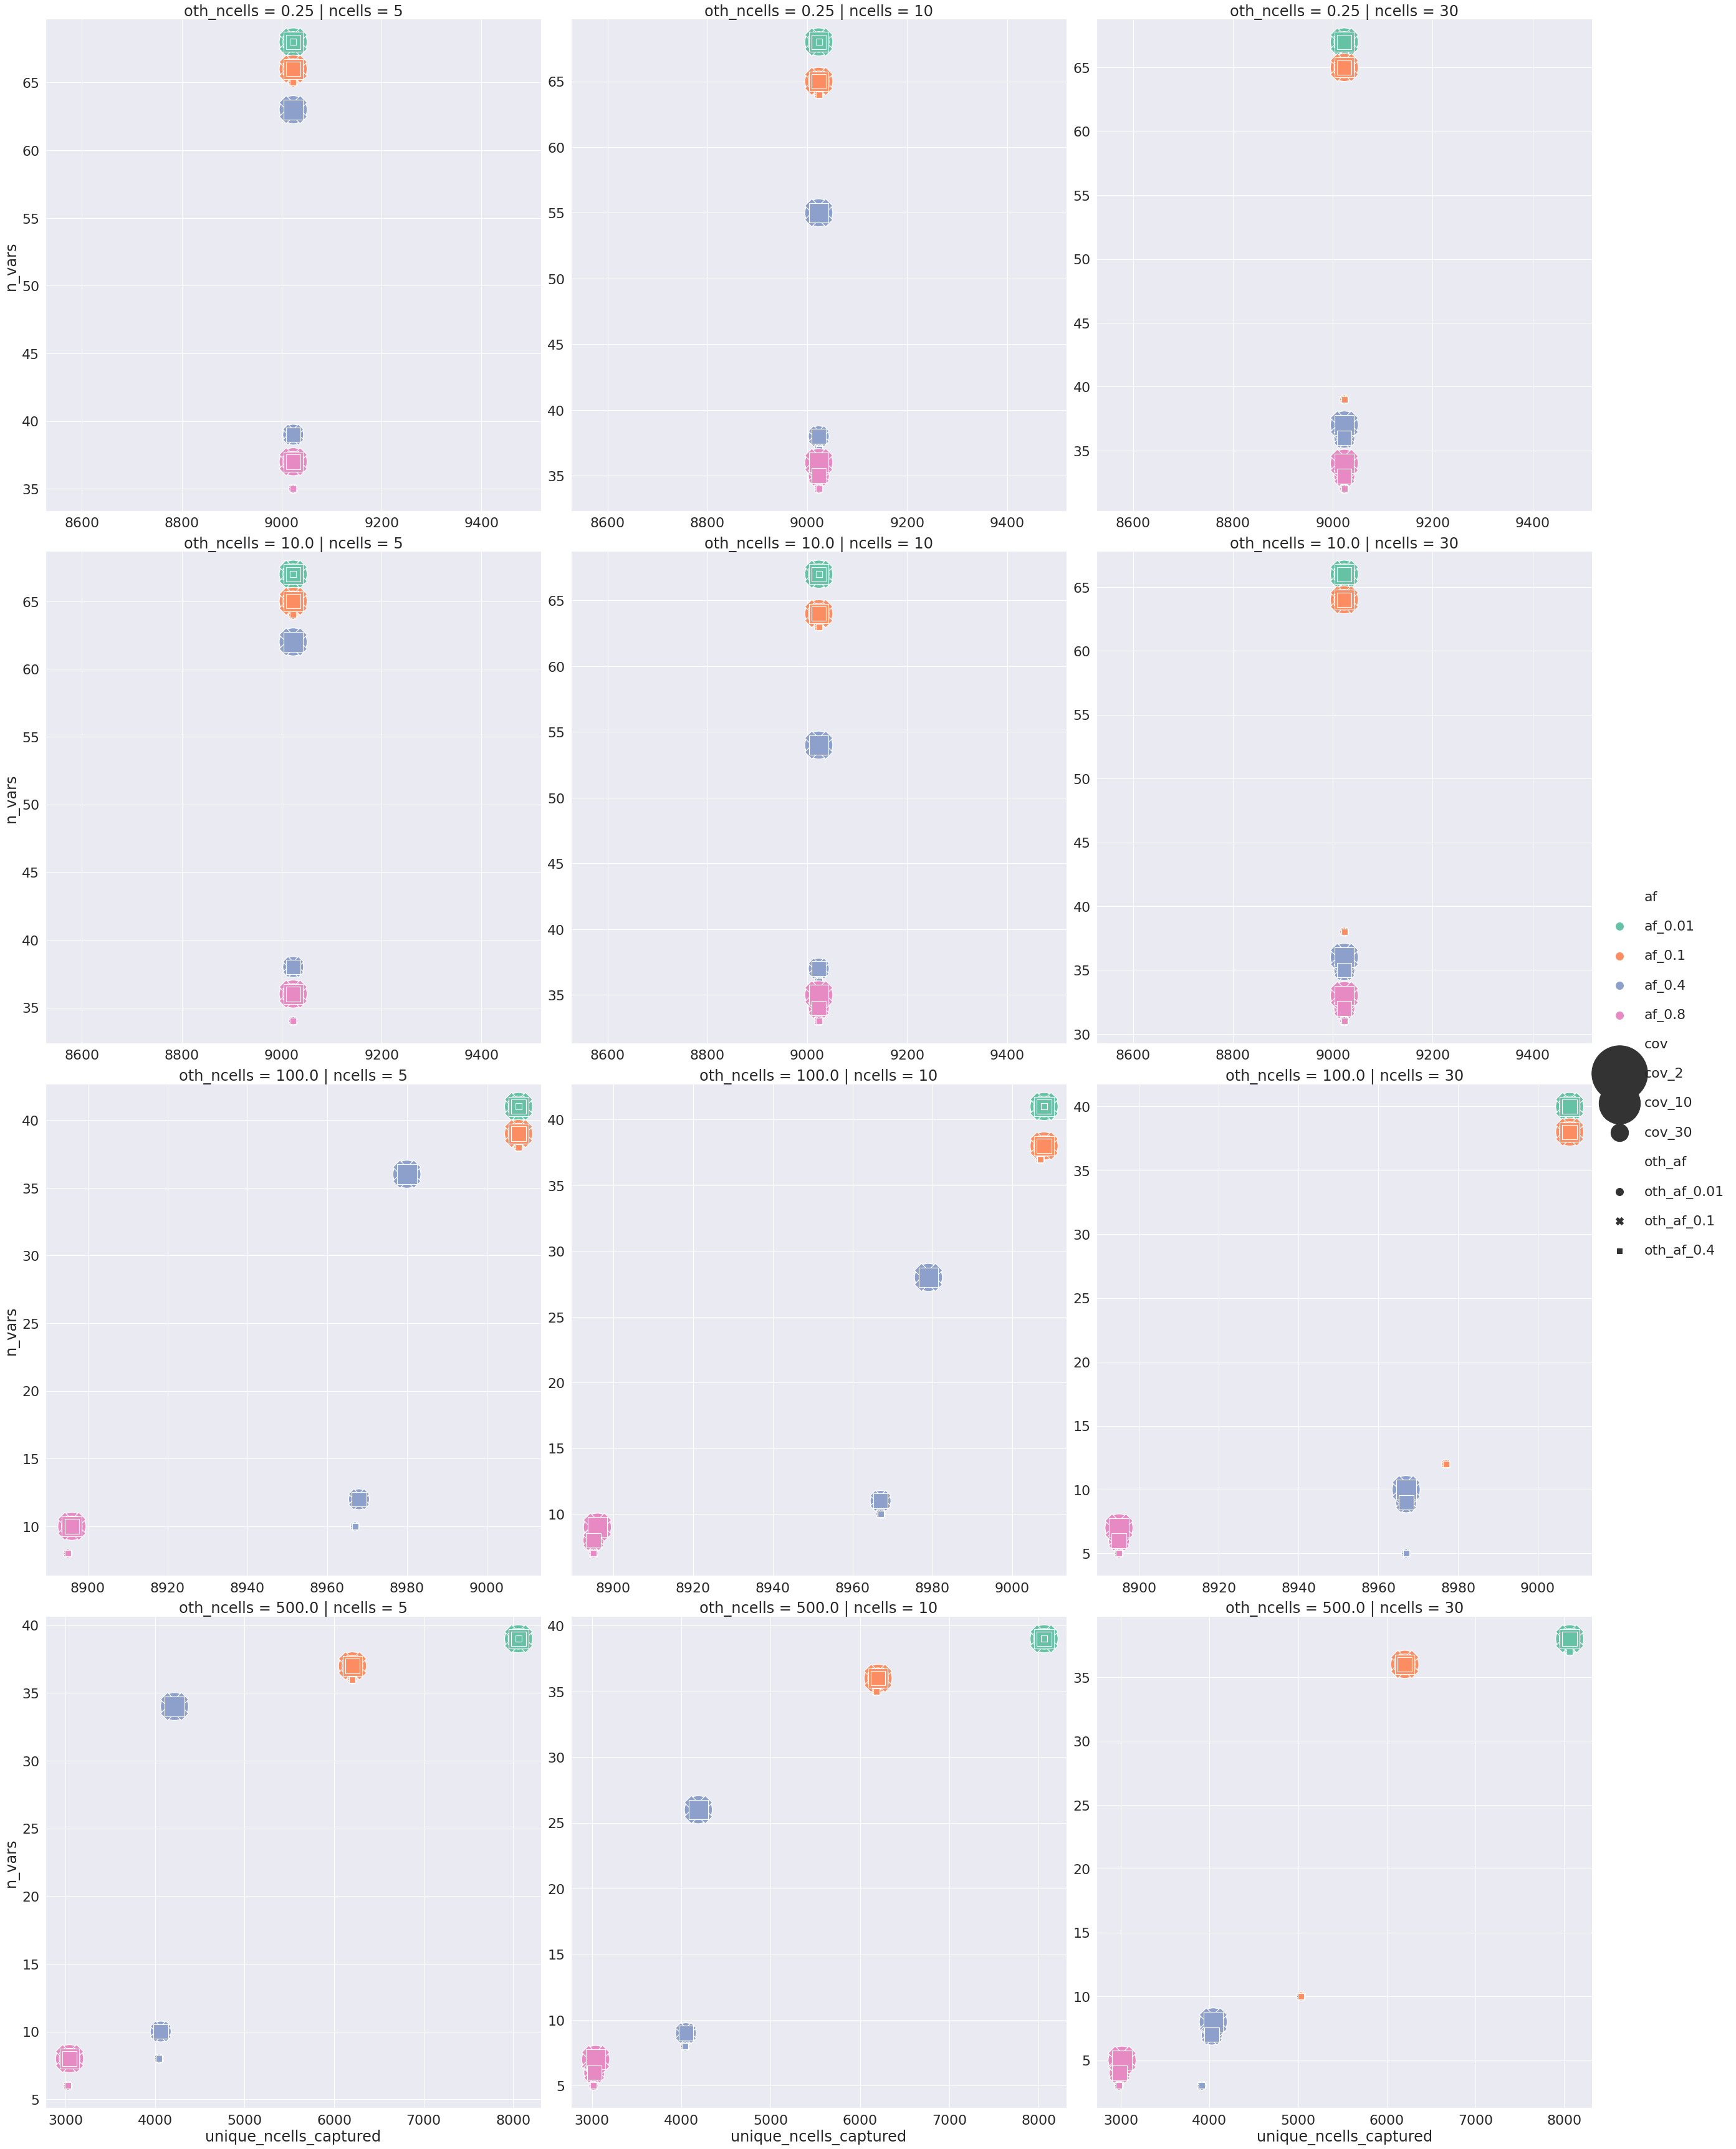

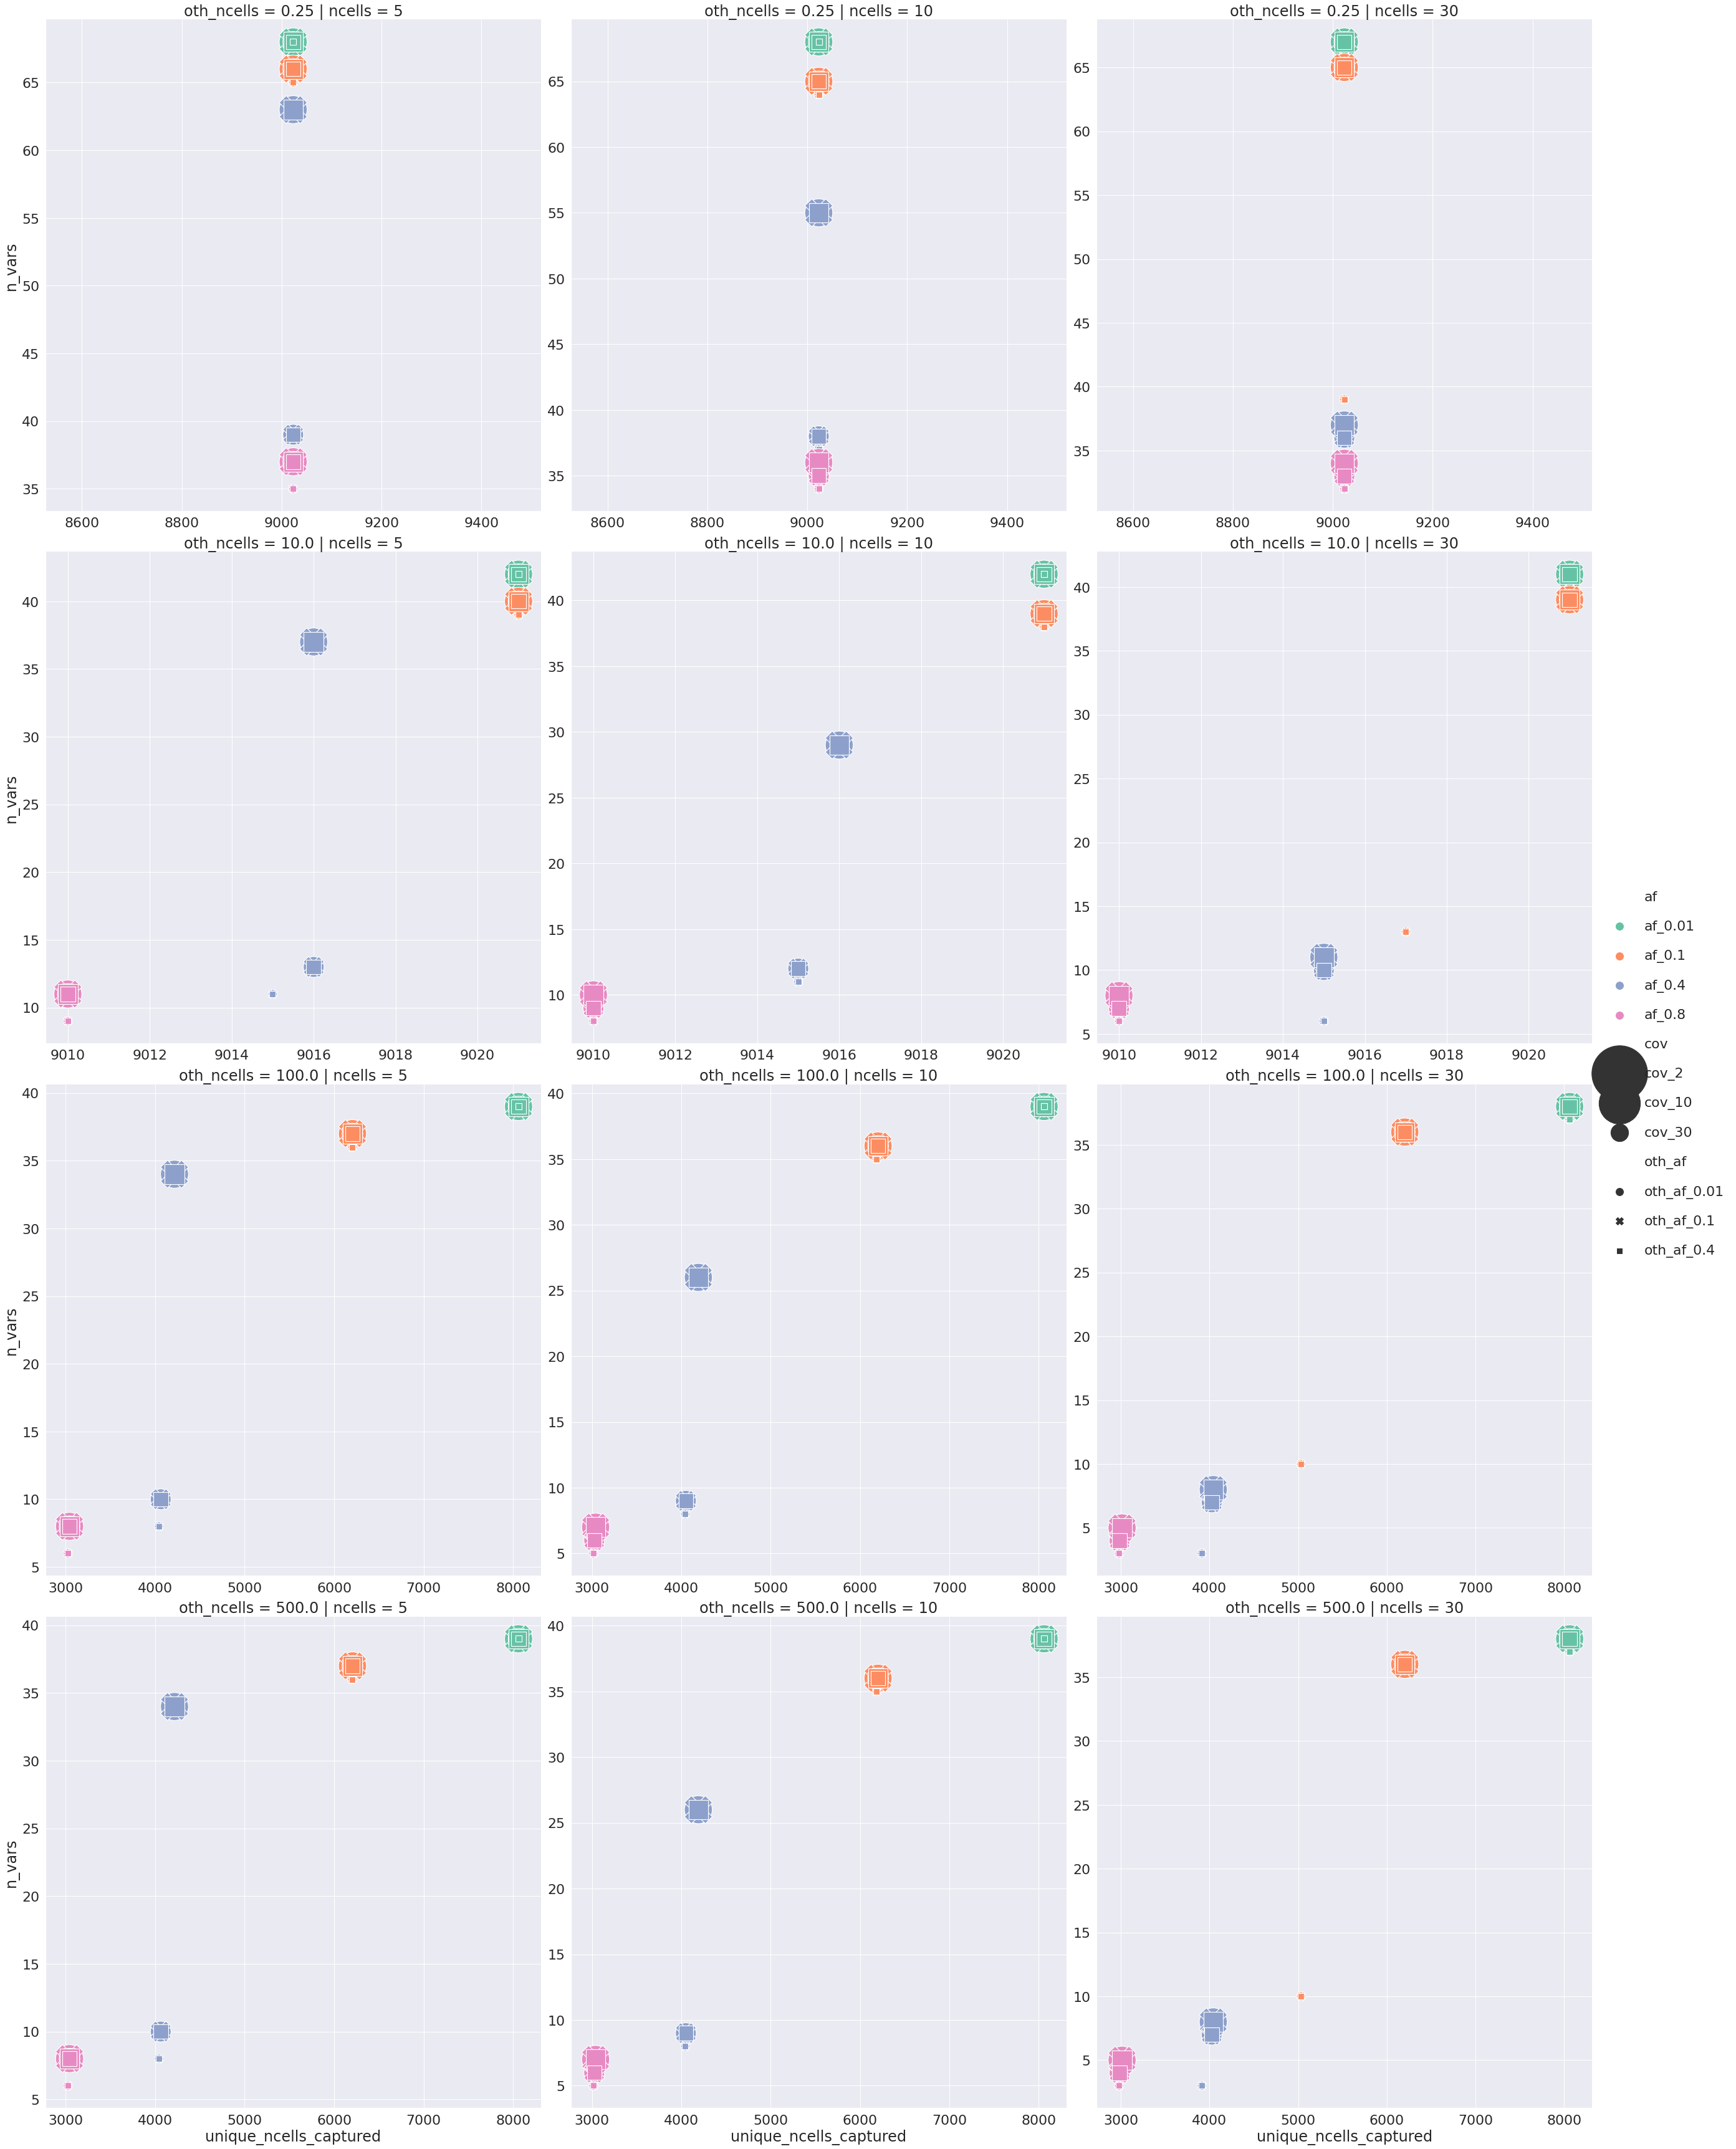

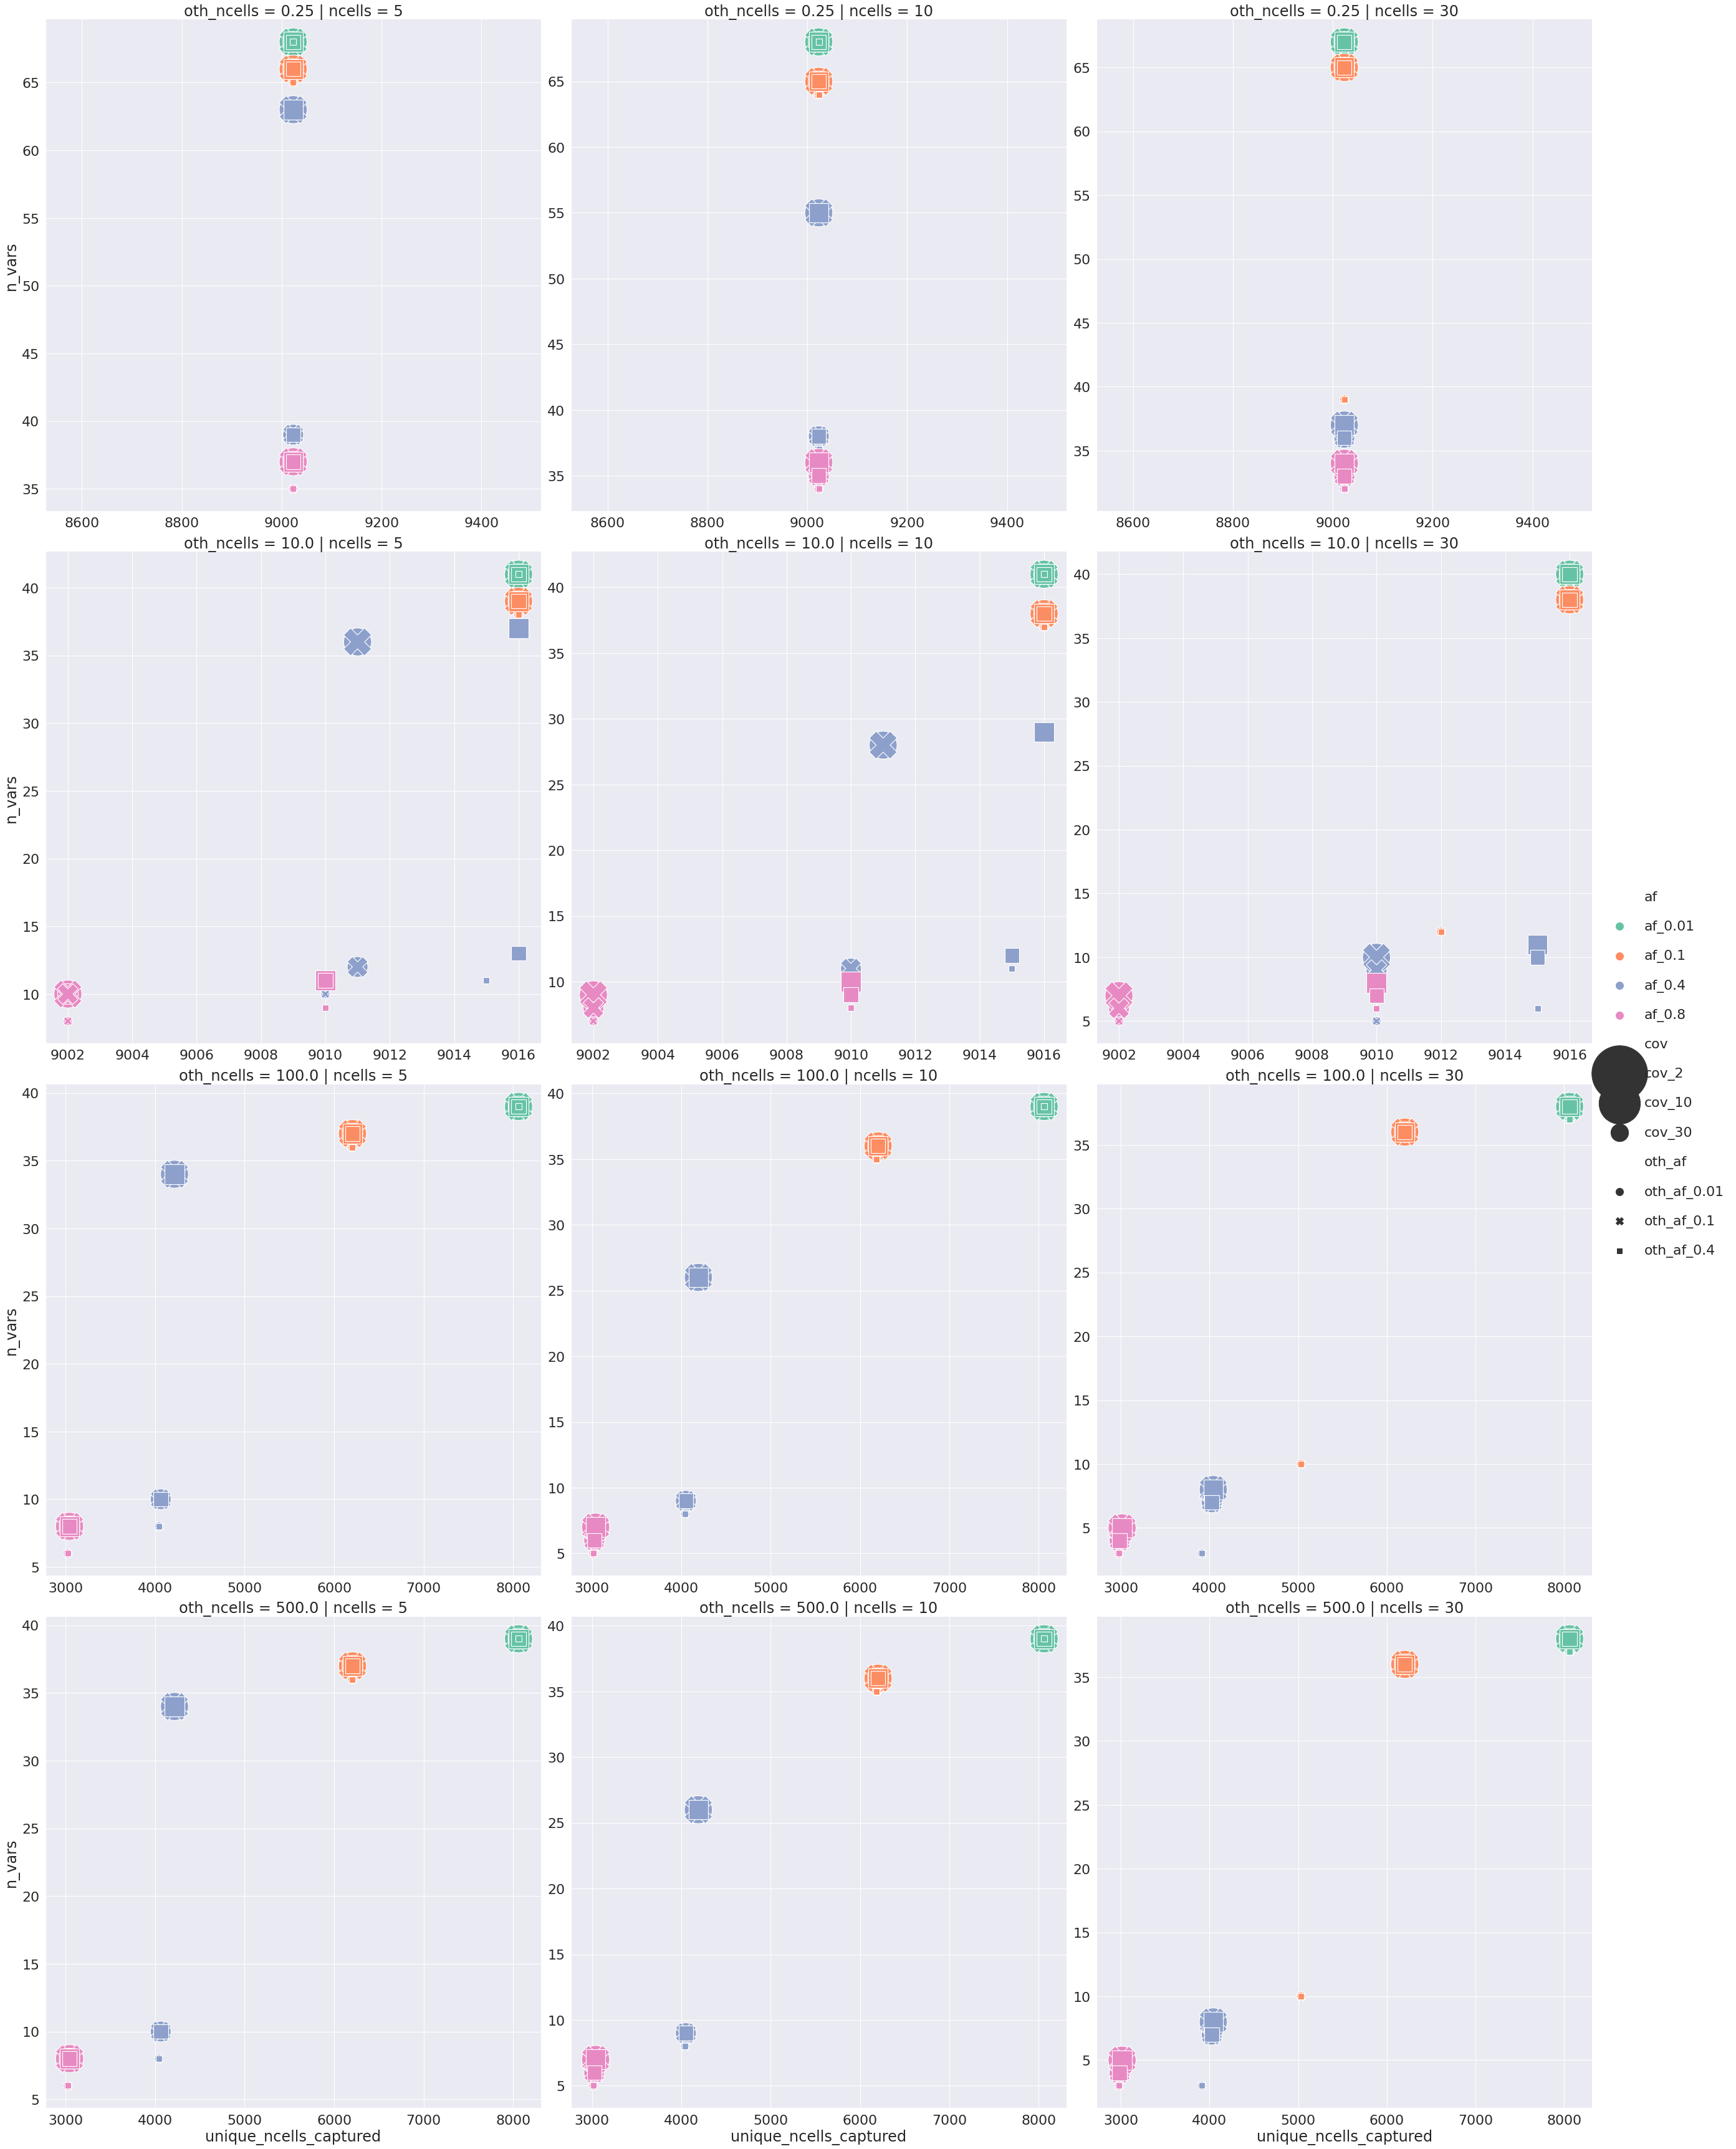

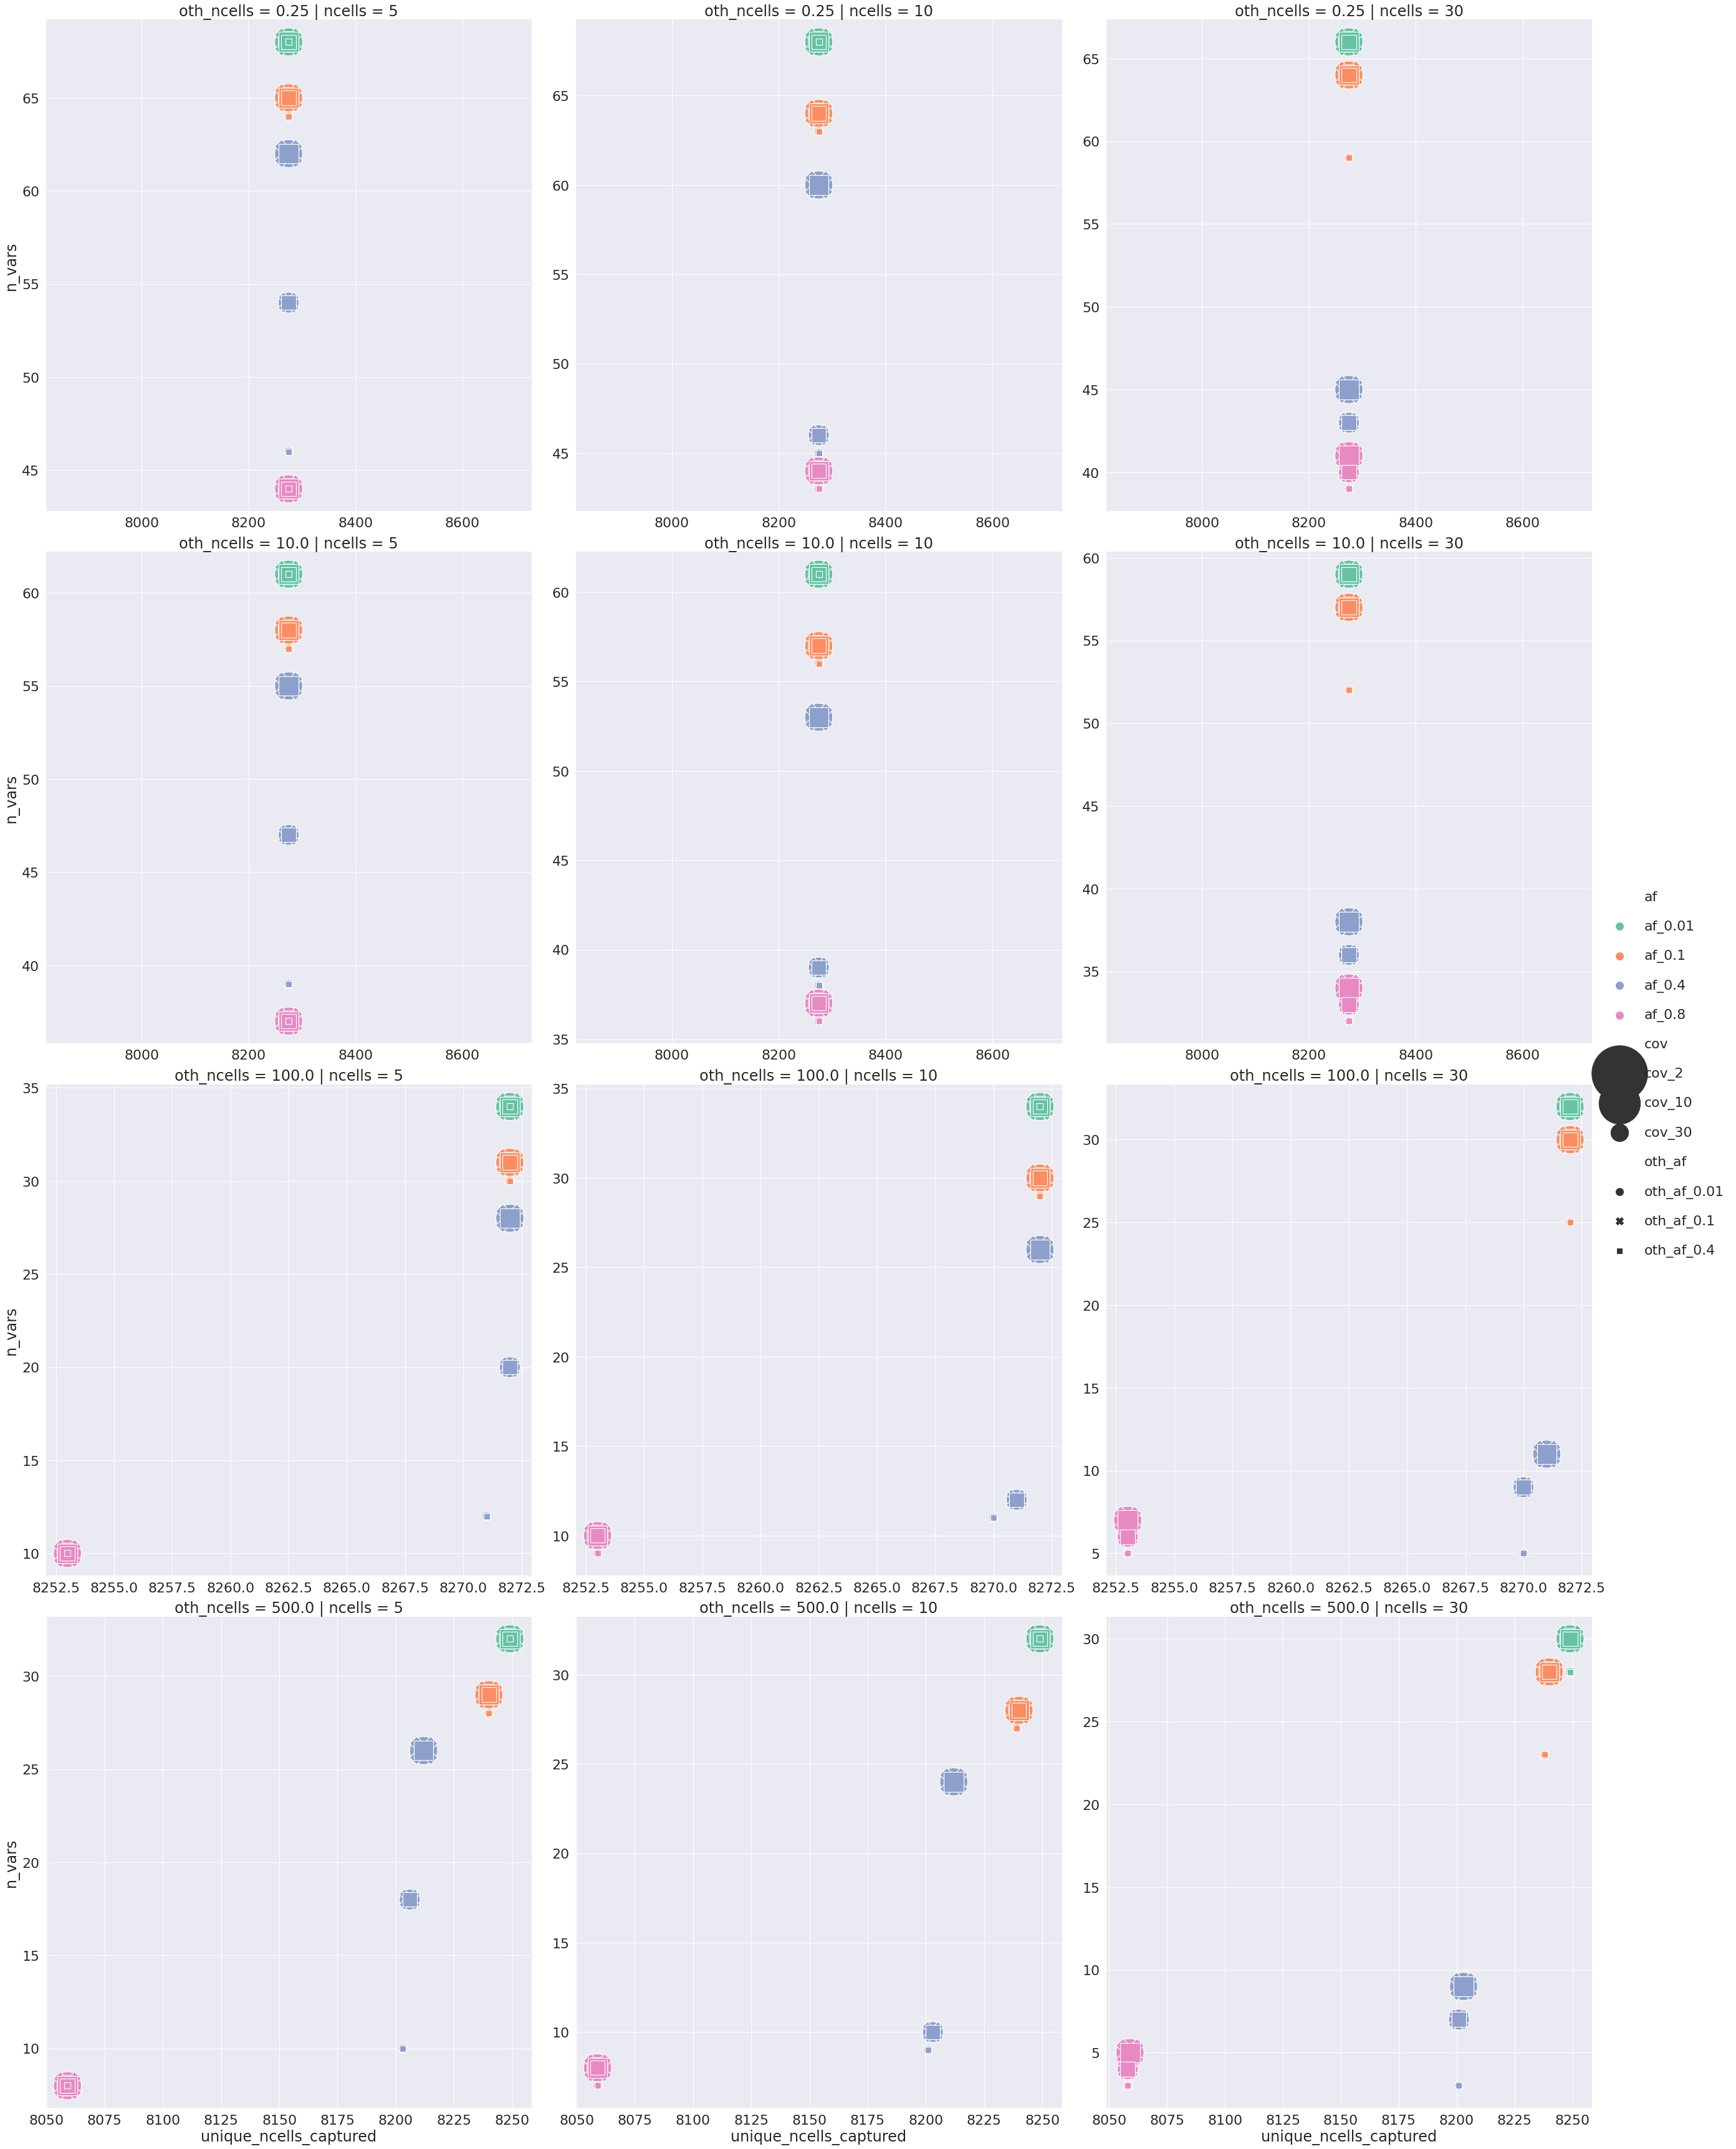

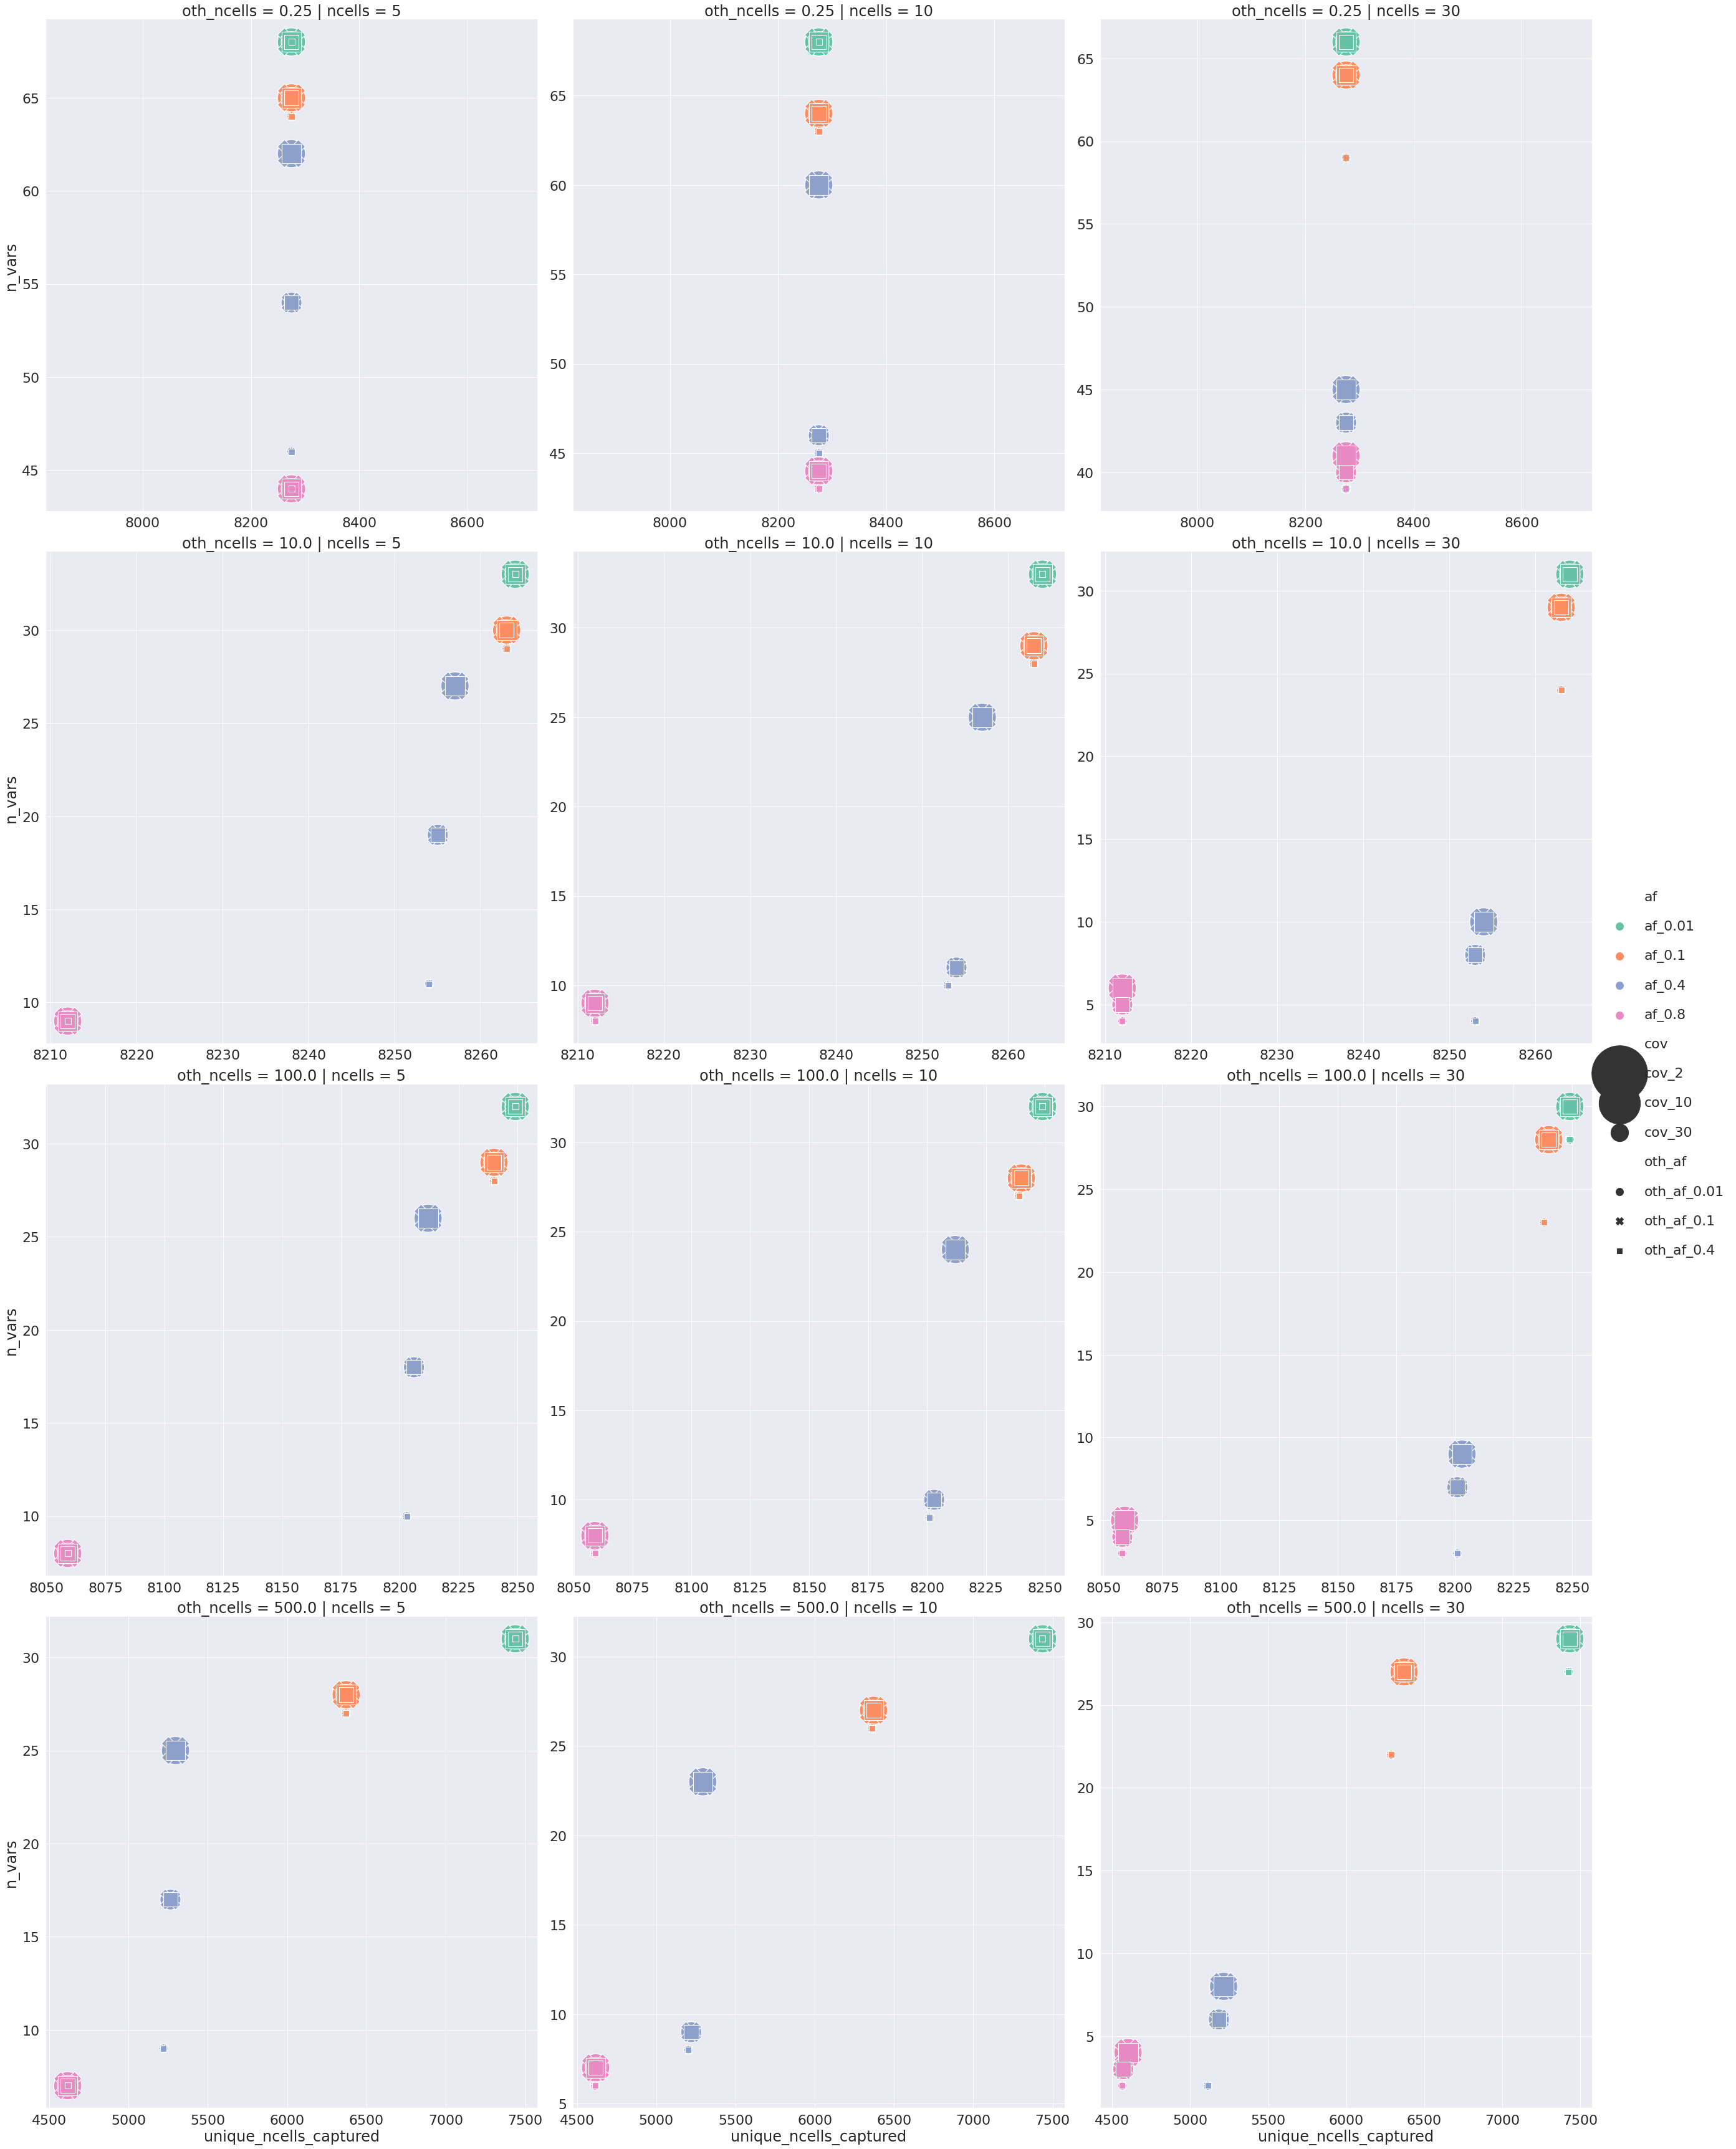

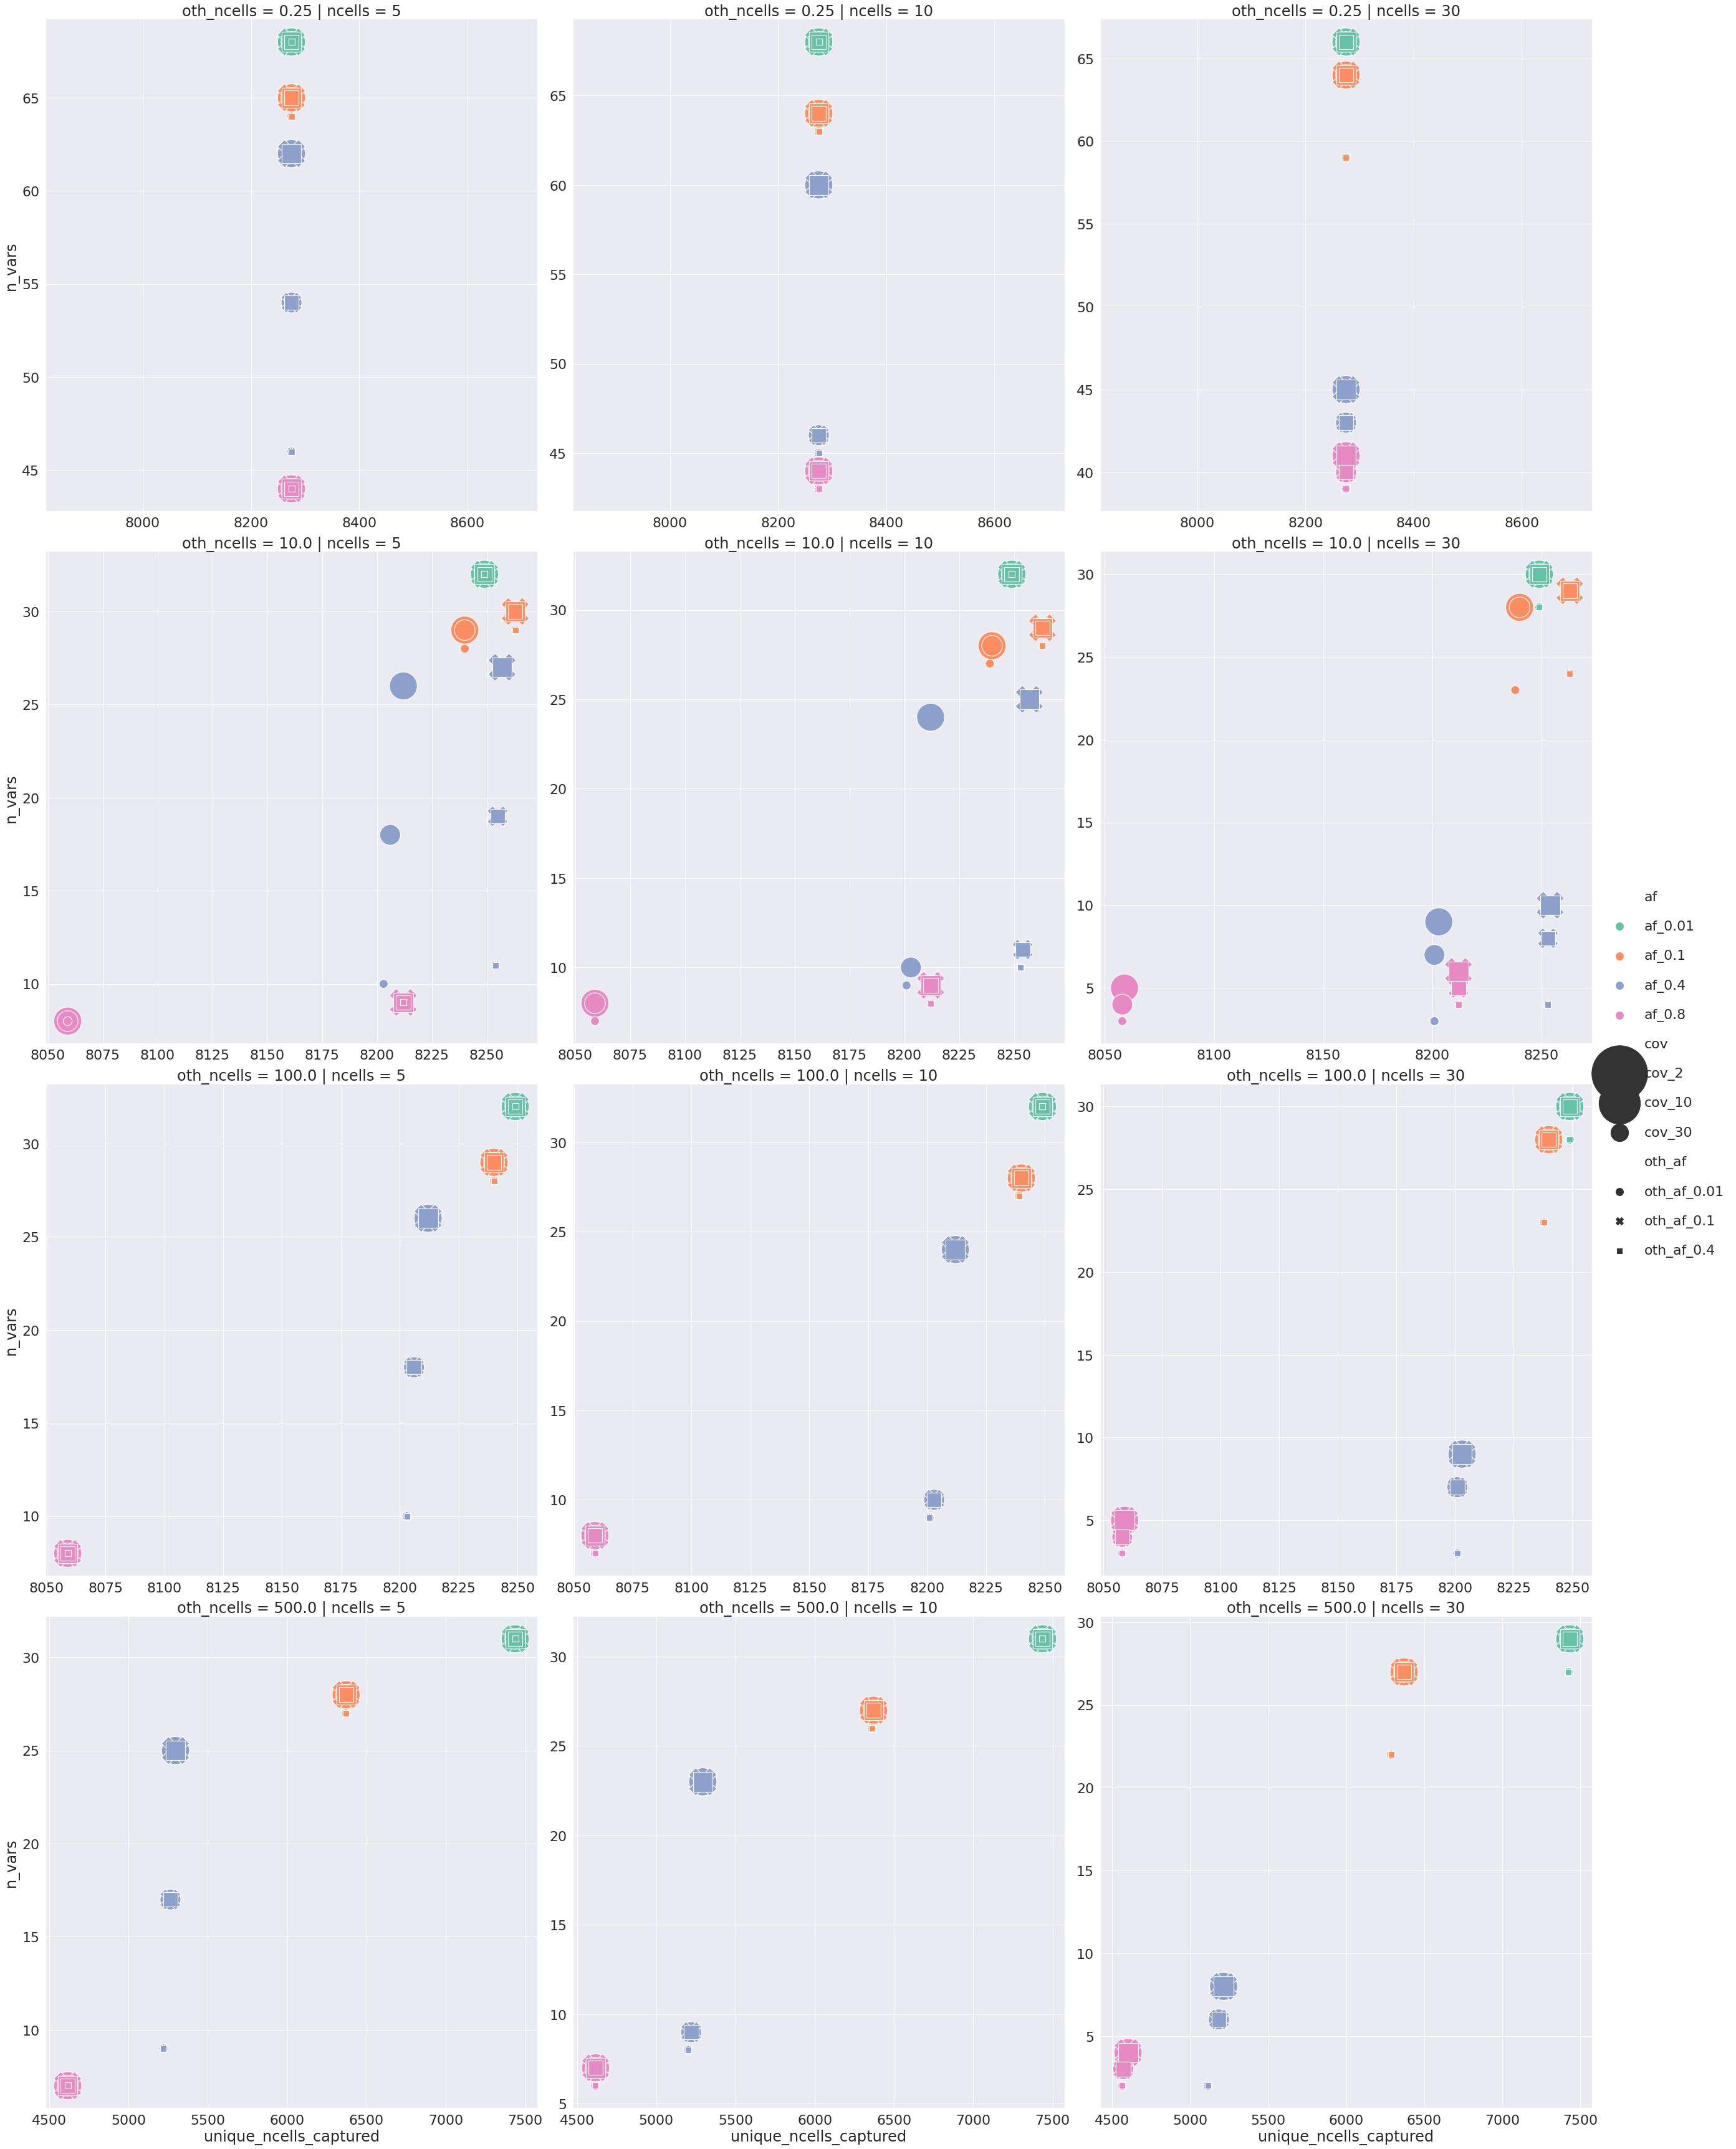

In [10]:
%matplotlib inline
# for d in params_d:
#     params_d[d]["log2_unique_ncells_captured"] =np.log2(1+params_d[d]["unique_ncells_captured"].astype(int))
#     g = sns.FacetGrid(data=params_d[d], legend_out=True, 
#                       col="ncells", row="oth_ncells",  height=12, sharex=False, sharey=False, 
#                       )
#     g.map_dataframe(sns.scatterplot, x="log2_unique_ncells_captured", y="n_vars", palette='Set2',
#                     hue="af",style="oth_af", size="cov", size_order = [f"cov_{x}" for x in cov_order],
#                     hue_order=[f"af_{x}" for x in af_order], style_order=[f"oth_af_{x}" for x in oth_af_order],
#                    sizes=(200, 2000), x_jitter=True, y_jitter=True)
#     g.add_legend(markerscale=2,labelspacing=1.2)
#     plt.savefig(join(outdir, f"donor{d}_params_scatter_diffAxis.png"))

for d in params_d:
    for oth_cov, val in params_d[d].groupby("oth_cov"):
        print('oth_cov', oth_cov)
        val["log2_unique_ncells_captured"] =np.log2(1+val["unique_ncells_captured"].astype(int))
        g = sns.FacetGrid(data=val, legend_out=True, 
                          col="ncells", row="oth_ncells",  height=12, sharex=False, sharey=False, 
                          )
        g.map_dataframe(sns.scatterplot, x="unique_ncells_captured", y="n_vars", palette='Set2',
                        hue="af",style="oth_af", size="cov", size_order = [f"cov_{x}" for x in cov_order],
                        hue_order=[f"af_{x}" for x in af_order], style_order=[f"oth_af_{x}" for x in oth_af_order],
                       sizes=(200, 2000), x_jitter=True, y_jitter=True)
        g.add_legend(markerscale=2,labelspacing=1.2)
        plt.savefig(join(outdir, f"donor{d}_othcov_{oth_cov}_params_scatter_diffAxis.png"))

In [11]:
# %matplotlib inline
# g = sns.FacetGrid(data=params_d[d], legend_out=True, 
#                   col="ncells", row="oth_ncells",  height=12, sharex=True, sharey=True, 
#                   )
# g.map_dataframe(sns.scatterplot, x="log2_unique_ncells_captured", y="n_vars", palette='Set2',
#                 hue="af",style="oth_af", size="cov", size_order = [f"cov_{x}" for x in cov_order],
#                 hue_order=[f"af_{x}" for x in af_order], style_order=[f"oth_af_{x}" for x in oth_af_order],
#                sizes=(200, 2000), x_jitter=True, y_jitter=True)
# g.add_legend(markerscale=2,labelspacing=1.2)

In [12]:
# def draw_heatmap(*args, **kwargs):
#     data = kwargs.pop('data')
#     #print(data.head())
#     d = data.pivot(index=args[1], columns=args[0], values=args[2]).fillna(0)
    
#     d_full = pd.DataFrame(index=clones_order, columns=variants_order)
#     d_full.loc[:,:] = 0
#     d_full.loc[d.index,d.columns] = d
#     d_full = d_full.astype(float)
#     #print(d_full.head())

#     sns.heatmap(d_full, cbar_kws = dict(orientation="horizontal"), **kwargs)
#     return
# def scatter(*args, **kwargs):
#     data = kwargs.pop('data')
#     data = data.astype({"af":object, "oth_af":object})
    
#     sns.scatterplot(data=data, x=args[0], y=args[1], style=args[2], hue=args[3], size=args[4],
#                    sizes=(200, 2000), x_jitter=True, y_jitter=True)
#     plt.legend()
#     return
    
# for d in params_d:
#     sns.set(font_scale=2)
#     params_d[d] = params_d[d].astype(object) #{"af":object, "oth_af":object})
#     g = sns.FacetGrid(data=params_d[d], legend_out=True, 
#                       col="ncells", row="oth_ncells",  height=12, sharex=True, sharey=True, 
#                       palette="Set2")
#     #g.map_dataframe(scatter, 'unique_ncells_captured','n_vars', "oth_af", "af", "cov")#, cbar=False)
#     #sns.relplot(data=df, row='smoker', col='day', x='total_bill', y='tip', hue='time', style='sex', facet_kws=dict(sharex=False, sharey=False))
# #     sns.relplot(data=params_d[d].astype({"af":object, "oth_af":object}),  col="ncells", row="oth_ncells",  height=12,
# #                 style='oth_af', hue="af", size="cov", facet_kws=dict(sharex=True, sharey=True))
#     g.map_dataframe(sns.scatterplot, x="unique_ncells_captured", y="n_vars", 
#                     hue="af",style="oth_af", size="cov",
#                    sizes=(200, 2000), x_jitter=True, y_jitter=True)
#     g.add_legend(fontsize="x-large")
    
#     #plt.legend(fontsize="x-large") # using a named size


#     plt.savefig(join(outdir, f"donor{d}_params_scatter.png"))